# Task I: Circuits

C:\Users\jenso\AppData\Local\Temp\ipykernel_32712\644367293.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


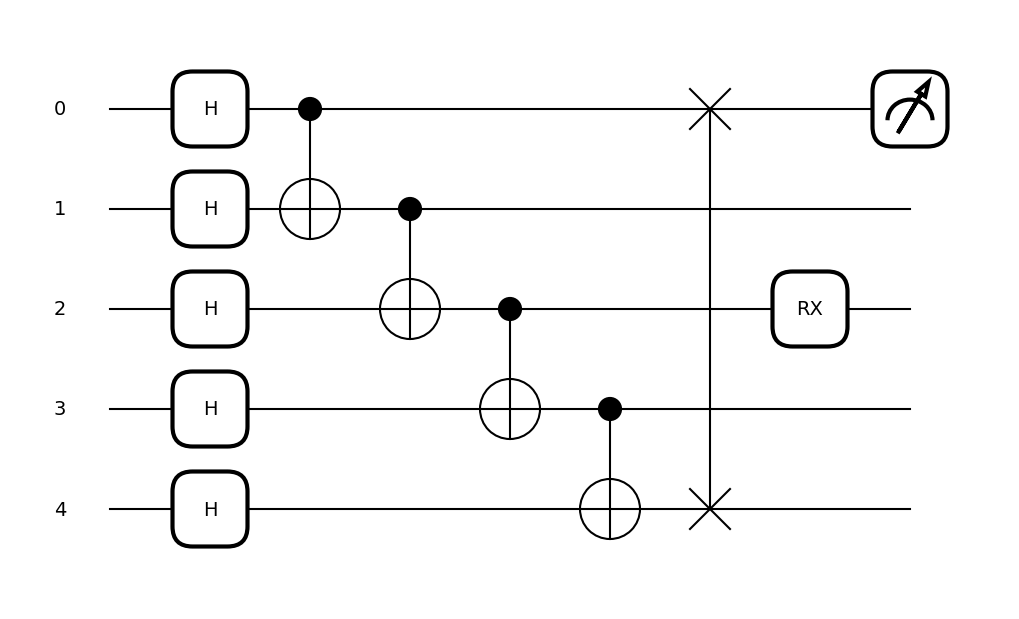

In [38]:
import pennylane as qml
from pennylane import numpy as np


dev = qml.device('default.qubit', wires=5)

@qml.qnode(dev)
def quantum_circuit():
    
    for i in range(5):
        qml.Hadamard(wires=i)

    
    for control, target in [(0,1), (1,2), (2,3), (3,4)]:
        qml.CNOT(wires=[control, target])

    
    qml.SWAP(wires=[0, 4])

    
    qml.RX(np.pi/2, wires=2)

    
    return qml.expval(qml.PauliZ(0))


quantum_circuit()


fig, ax = qml.draw_mpl(quantum_circuit)()
fig.show()


In [39]:
import cirq
import numpy as np


q0, q1, q2, q3, q4 = cirq.LineQubit.range(5)

circuit = cirq.Circuit()


circuit.append(cirq.H(q1))


circuit.append(cirq.rx(np.pi / 3)(q2))


circuit.append([cirq.H(q3), cirq.H(q4)])

circuit.append(cirq.H(q0))


circuit.append(cirq.CSWAP(q0, q1, q3))
circuit.append(cirq.CSWAP(q0, q2, q4))


circuit.append(cirq.H(q0))


circuit.append(cirq.measure(q0, key='result'))


print("Quantum Circuit:\n")
print(circuit)


simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)


print("\nMeasurement results:")
print(result.histogram(key='result'))

Quantum Circuit:

0: ───H────────────@───@───H───M('result')───
                   │   │
1: ───H────────────×───┼─────────────────────
                   │   │
2: ───Rx(0.333π)───┼───×─────────────────────
                   │   │
3: ───H────────────×───┼─────────────────────
                       │
4: ───H────────────────×─────────────────────

Measurement results:
Counter({0: 735, 1: 265})


# Task II: GNN

The point-cloud data is first processed by identifying spatial relationships between points. The following key considerations were taken when projecting the dataset into a graph of interconnected nodes and edges:

Neighborhood Definition:
A nearest-neighbors (or radius-based) approach is applied so that each point is considered a node, and edges are created whenever two points lie within a determined distance threshold. This allows the graph to capture local geometric features while keeping the overall structure sparse enough for efficient processing.

Edge Weighting:
Depending on the distance or similarity metrics, edge weights can be assigned. Weighting edges by inverse Euclidean distances or feature similarity ensures that strongly related nodes have more influence during message passing or diffusion operations.

Graph Connectivity:
The method guarantees that even in sparse regions of the point cloud, nodes are adequately connected by dynamically adapting the connectivity threshold. This helps in preserving the overall topology and prevents isolated nodes that could hurt performance.

Dimensionality Reduction & Feature Encoding:
Features derived from each point (possibly including coordinates and local curvature statistics) are embedded into higher-dimensional spaces before being used in the graph. This is important for both architectures, ensuring that the downstream network—whether classical or quantum—receives informative embeddings.

In [41]:
import torch
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Dataset, Data

def build_knn_graph(points, k=8):
    M = points.shape[0]

    dist_matrix = np.zeros((M, M))
    for i in range(M):
        for j in range(i+1, M):
            d_eta = points[i, 0] - points[j, 0]
            d_phi = points[i, 1] - points[j, 1]
            dR = np.sqrt(d_eta**2 + d_phi**2)
            dist_matrix[i, j] = dR
            dist_matrix[j, i] = dR
    
    edges = []
    for i in range(M):
        neighbors = np.argsort(dist_matrix[i])[:k]  
        for nbr in neighbors:
            if nbr != i:
                edges.append([i, nbr])
    edge_index = torch.tensor(edges, dtype=torch.long).t()  # shape (2, E)
    return edge_index

class QGDataset(Dataset):
    def __init__(self, X, y, k=8, transform=None):
        """
        X: shape (N, M, 4)
        y: shape (N,)
        k: k-NN 的 k
        """
        super().__init__(None, transform, None)
        self.X = X
        self.y = y
        self.k = k
    
    def len(self):
        return len(self.X)
    
    def get(self, idx):
        # (shape: (M, 4))
        jet = self.X[idx]
        label = self.y[idx]
        

        x = torch.tensor(jet, dtype=torch.float)  # shape (M, 4)
        

        # jet[:, 1] = eta; jet[:, 2] = phi
        eta_phi = jet[:, 1:3]
        edge_index = build_knn_graph(eta_phi, k=self.k)
        
        y_tensor = torch.tensor([label], dtype=torch.long)
        
        data = Data(x=x, edge_index=edge_index, y=y_tensor)
        return data

from torch_geometric.loader import DataLoader

data = np.load("QG_jets.npz")
X = data["X"]  # shape: (100000, M, 4)
y = data["y"]  # shape: (100000,)

# train / test split
N = len(X)
indices = np.arange(N)
np.random.shuffle(indices)
train_size = int(0.1 * N)
train_idx = indices[:train_size]
test_idx  = indices[train_size:]

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]


train_dataset = QGDataset(X_train, y_train, k=8)
test_dataset  = QGDataset(X_test,  y_test,  k=8)

#  DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [42]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

# === 1. GCN ===
class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_dim=64, out_dim=2):
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # global mean pooling
        x = global_mean_pool(x, batch)
        return self.fc(x)

# === 2. GAT ===
class GATClassifier(nn.Module):
    def __init__(self, in_channels, hidden_dim=64, out_dim=2, heads=4):
        super(GATClassifier, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_dim, heads=heads)
        #  output channel = hidden_dim * heads
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads)
        self.fc = nn.Linear(hidden_dim * heads, out_dim)
    
    def forward(self, x, edge_index, batch):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        
        x = global_mean_pool(x, batch)
        return self.fc(x)


In [43]:
def train_one_epoch(model, optimizer, loader, device):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.num_graphs
        
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc

def test(model, loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
        
        total_loss += loss.item() * data.num_graphs
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc


Creating dataset: 100%|██████████| 100000/100000 [01:47<00:00, 931.98it/s]


Training GCN...


Epochs:   2%|▏         | 1/50 [00:16<13:24, 16.42s/it]

Epoch 1/50, Train Loss: 0.6969, Train Acc: 0.5587, Val Loss: 0.6915, Val Acc: 0.5039


Epochs:   4%|▍         | 2/50 [00:33<13:40, 17.09s/it]

Epoch 2/50, Train Loss: 0.6870, Train Acc: 0.5686, Val Loss: 0.6877, Val Acc: 0.5167


Epochs:   6%|▌         | 3/50 [00:51<13:28, 17.21s/it]

Epoch 3/50, Train Loss: 0.6855, Train Acc: 0.5706, Val Loss: 0.6947, Val Acc: 0.5059


Epochs:   8%|▊         | 4/50 [01:08<13:06, 17.10s/it]

Epoch 4/50, Train Loss: 0.6845, Train Acc: 0.5752, Val Loss: 0.6832, Val Acc: 0.5416


Epochs:  10%|█         | 5/50 [01:21<11:39, 15.55s/it]

Epoch 5/50, Train Loss: 0.6813, Train Acc: 0.5813, Val Loss: 0.6845, Val Acc: 0.5243


Epochs:  12%|█▏        | 6/50 [01:34<10:52, 14.83s/it]

Epoch 6/50, Train Loss: 0.6716, Train Acc: 0.5959, Val Loss: 0.6576, Val Acc: 0.5995


Epochs:  14%|█▍        | 7/50 [01:47<10:17, 14.36s/it]

Epoch 7/50, Train Loss: 0.6267, Train Acc: 0.6507, Val Loss: 0.5895, Val Acc: 0.6816


Epochs:  16%|█▌        | 8/50 [02:01<09:49, 14.03s/it]

Epoch 8/50, Train Loss: 0.5797, Train Acc: 0.6962, Val Loss: 0.5661, Val Acc: 0.7004


Epochs:  18%|█▊        | 9/50 [02:13<09:15, 13.55s/it]

Epoch 9/50, Train Loss: 0.5545, Train Acc: 0.7164, Val Loss: 0.5381, Val Acc: 0.7284


Epochs:  20%|██        | 10/50 [02:27<09:09, 13.74s/it]

Epoch 10/50, Train Loss: 0.5427, Train Acc: 0.7308, Val Loss: 0.5274, Val Acc: 0.7411


Epochs:  22%|██▏       | 11/50 [02:41<08:59, 13.84s/it]

Epoch 11/50, Train Loss: 0.5379, Train Acc: 0.7333, Val Loss: 0.5288, Val Acc: 0.7417


Epochs:  24%|██▍       | 12/50 [02:55<08:40, 13.70s/it]

Epoch 12/50, Train Loss: 0.5323, Train Acc: 0.7379, Val Loss: 0.5205, Val Acc: 0.7451


Epochs:  26%|██▌       | 13/50 [03:08<08:23, 13.61s/it]

Epoch 13/50, Train Loss: 0.5314, Train Acc: 0.7391, Val Loss: 0.5251, Val Acc: 0.7420


Epochs:  28%|██▊       | 14/50 [03:21<08:04, 13.46s/it]

Epoch 14/50, Train Loss: 0.5282, Train Acc: 0.7413, Val Loss: 0.5376, Val Acc: 0.7264


Epochs:  30%|███       | 15/50 [03:34<07:37, 13.07s/it]

Epoch 15/50, Train Loss: 0.5257, Train Acc: 0.7422, Val Loss: 0.5300, Val Acc: 0.7366


Epochs:  32%|███▏      | 16/50 [03:46<07:18, 12.91s/it]

Epoch 16/50, Train Loss: 0.5252, Train Acc: 0.7438, Val Loss: 0.5265, Val Acc: 0.7350


Epochs:  34%|███▍      | 17/50 [03:59<07:10, 13.06s/it]

Epoch 17/50, Train Loss: 0.5230, Train Acc: 0.7442, Val Loss: 0.5175, Val Acc: 0.7495


Epochs:  36%|███▌      | 18/50 [04:12<06:54, 12.95s/it]

Epoch 18/50, Train Loss: 0.5229, Train Acc: 0.7439, Val Loss: 0.5201, Val Acc: 0.7504


Epochs:  38%|███▊      | 19/50 [04:24<06:34, 12.71s/it]

Epoch 19/50, Train Loss: 0.5195, Train Acc: 0.7478, Val Loss: 0.5249, Val Acc: 0.7375


Epochs:  40%|████      | 20/50 [04:37<06:22, 12.73s/it]

Epoch 20/50, Train Loss: 0.5199, Train Acc: 0.7462, Val Loss: 0.5249, Val Acc: 0.7388


Epochs:  42%|████▏     | 21/50 [04:51<06:20, 13.13s/it]

Epoch 21/50, Train Loss: 0.5181, Train Acc: 0.7488, Val Loss: 0.5176, Val Acc: 0.7488


Epochs:  44%|████▍     | 22/50 [05:04<06:05, 13.05s/it]

Epoch 22/50, Train Loss: 0.5177, Train Acc: 0.7483, Val Loss: 0.5198, Val Acc: 0.7451


Epochs:  46%|████▌     | 23/50 [05:18<05:56, 13.20s/it]

Epoch 23/50, Train Loss: 0.5174, Train Acc: 0.7483, Val Loss: 0.5162, Val Acc: 0.7517


Epochs:  48%|████▊     | 24/50 [05:30<05:38, 13.03s/it]

Epoch 24/50, Train Loss: 0.5172, Train Acc: 0.7498, Val Loss: 0.5166, Val Acc: 0.7483


Epochs:  50%|█████     | 25/50 [05:42<05:19, 12.80s/it]

Epoch 25/50, Train Loss: 0.5151, Train Acc: 0.7504, Val Loss: 0.5137, Val Acc: 0.7545


Epochs:  52%|█████▏    | 26/50 [05:55<05:08, 12.84s/it]

Epoch 26/50, Train Loss: 0.5140, Train Acc: 0.7504, Val Loss: 0.5109, Val Acc: 0.7535


Epochs:  54%|█████▍    | 27/50 [06:08<04:57, 12.91s/it]

Epoch 27/50, Train Loss: 0.5145, Train Acc: 0.7494, Val Loss: 0.5178, Val Acc: 0.7459


Epochs:  56%|█████▌    | 28/50 [06:22<04:46, 13.04s/it]

Epoch 28/50, Train Loss: 0.5124, Train Acc: 0.7526, Val Loss: 0.5105, Val Acc: 0.7544


Epochs:  58%|█████▊    | 29/50 [06:35<04:34, 13.09s/it]

Epoch 29/50, Train Loss: 0.5128, Train Acc: 0.7526, Val Loss: 0.5263, Val Acc: 0.7419


Epochs:  60%|██████    | 30/50 [06:48<04:20, 13.05s/it]

Epoch 30/50, Train Loss: 0.5121, Train Acc: 0.7535, Val Loss: 0.5080, Val Acc: 0.7574


Epochs:  62%|██████▏   | 31/50 [07:01<04:07, 13.03s/it]

Epoch 31/50, Train Loss: 0.5103, Train Acc: 0.7552, Val Loss: 0.5103, Val Acc: 0.7531


Epochs:  64%|██████▍   | 32/50 [07:14<03:53, 12.97s/it]

Epoch 32/50, Train Loss: 0.5098, Train Acc: 0.7553, Val Loss: 0.5089, Val Acc: 0.7553


Epochs:  66%|██████▌   | 33/50 [07:27<03:42, 13.08s/it]

Epoch 33/50, Train Loss: 0.5099, Train Acc: 0.7543, Val Loss: 0.5083, Val Acc: 0.7578


Epochs:  68%|██████▊   | 34/50 [07:40<03:30, 13.17s/it]

Epoch 34/50, Train Loss: 0.5091, Train Acc: 0.7547, Val Loss: 0.5076, Val Acc: 0.7574


Epochs:  70%|███████   | 35/50 [07:53<03:15, 13.05s/it]

Epoch 35/50, Train Loss: 0.5075, Train Acc: 0.7568, Val Loss: 0.5087, Val Acc: 0.7566


Epochs:  72%|███████▏  | 36/50 [08:06<03:00, 12.87s/it]

Epoch 36/50, Train Loss: 0.5079, Train Acc: 0.7557, Val Loss: 0.5124, Val Acc: 0.7518


Epochs:  74%|███████▍  | 37/50 [08:18<02:46, 12.78s/it]

Epoch 37/50, Train Loss: 0.5072, Train Acc: 0.7554, Val Loss: 0.5099, Val Acc: 0.7563


Epochs:  76%|███████▌  | 38/50 [08:31<02:33, 12.77s/it]

Epoch 38/50, Train Loss: 0.5069, Train Acc: 0.7547, Val Loss: 0.5039, Val Acc: 0.7586


Epochs:  78%|███████▊  | 39/50 [08:44<02:19, 12.73s/it]

Epoch 39/50, Train Loss: 0.5040, Train Acc: 0.7591, Val Loss: 0.5049, Val Acc: 0.7567


Epochs:  80%|████████  | 40/50 [08:57<02:08, 12.84s/it]

Epoch 40/50, Train Loss: 0.5056, Train Acc: 0.7574, Val Loss: 0.4997, Val Acc: 0.7622


Epochs:  82%|████████▏ | 41/50 [09:10<01:55, 12.86s/it]

Epoch 41/50, Train Loss: 0.5046, Train Acc: 0.7597, Val Loss: 0.5015, Val Acc: 0.7589


Epochs:  84%|████████▍ | 42/50 [09:23<01:43, 12.90s/it]

Epoch 42/50, Train Loss: 0.5049, Train Acc: 0.7568, Val Loss: 0.5153, Val Acc: 0.7439


Epochs:  86%|████████▌ | 43/50 [09:41<01:41, 14.47s/it]

Epoch 43/50, Train Loss: 0.5045, Train Acc: 0.7594, Val Loss: 0.5036, Val Acc: 0.7611


Epochs:  88%|████████▊ | 44/50 [09:59<01:33, 15.62s/it]

Epoch 44/50, Train Loss: 0.5044, Train Acc: 0.7583, Val Loss: 0.4986, Val Acc: 0.7639


Epochs:  90%|█████████ | 45/50 [10:17<01:21, 16.35s/it]

Epoch 45/50, Train Loss: 0.5015, Train Acc: 0.7618, Val Loss: 0.5019, Val Acc: 0.7626


Epochs:  92%|█████████▏| 46/50 [10:35<01:07, 16.91s/it]

Epoch 46/50, Train Loss: 0.5035, Train Acc: 0.7582, Val Loss: 0.5016, Val Acc: 0.7610


Epochs:  94%|█████████▍| 47/50 [10:54<00:52, 17.35s/it]

Epoch 47/50, Train Loss: 0.5017, Train Acc: 0.7599, Val Loss: 0.5011, Val Acc: 0.7636


Epochs:  96%|█████████▌| 48/50 [11:12<00:35, 17.61s/it]

Epoch 48/50, Train Loss: 0.5025, Train Acc: 0.7610, Val Loss: 0.5138, Val Acc: 0.7556


Epochs:  98%|█████████▊| 49/50 [11:30<00:17, 17.79s/it]

Epoch 49/50, Train Loss: 0.5003, Train Acc: 0.7630, Val Loss: 0.4992, Val Acc: 0.7614


Epochs: 100%|██████████| 50/50 [11:49<00:00, 14.18s/it]


Epoch 50/50, Train Loss: 0.5009, Train Acc: 0.7600, Val Loss: 0.5127, Val Acc: 0.7511

Training EdgeConv...


Epochs:   2%|▏         | 1/50 [00:45<37:11, 45.55s/it]

Epoch 1/50, Train Loss: 0.6840, Train Acc: 0.5760, Val Loss: 0.6744, Val Acc: 0.5766


Epochs:   4%|▍         | 2/50 [01:30<36:22, 45.47s/it]

Epoch 2/50, Train Loss: 0.6730, Train Acc: 0.6000, Val Loss: 0.6721, Val Acc: 0.5733


Epochs:   6%|▌         | 3/50 [02:17<35:54, 45.85s/it]

Epoch 3/50, Train Loss: 0.6670, Train Acc: 0.6080, Val Loss: 0.6663, Val Acc: 0.5841


Epochs:   8%|▊         | 4/50 [03:03<35:24, 46.18s/it]

Epoch 4/50, Train Loss: 0.6627, Train Acc: 0.6125, Val Loss: 0.6984, Val Acc: 0.5223


Epochs:  10%|█         | 5/50 [03:49<34:26, 45.92s/it]

Epoch 5/50, Train Loss: 0.6474, Train Acc: 0.6258, Val Loss: 0.6423, Val Acc: 0.5965


Epochs:  12%|█▏        | 6/50 [04:35<33:39, 45.91s/it]

Epoch 6/50, Train Loss: 0.6185, Train Acc: 0.6599, Val Loss: 0.6753, Val Acc: 0.5707


Epochs:  14%|█▍        | 7/50 [05:10<30:25, 42.46s/it]

Epoch 7/50, Train Loss: 0.5937, Train Acc: 0.6832, Val Loss: 0.6091, Val Acc: 0.6634


Epochs:  16%|█▌        | 8/50 [05:41<27:04, 38.67s/it]

Epoch 8/50, Train Loss: 0.5826, Train Acc: 0.6931, Val Loss: 0.5750, Val Acc: 0.7005


Epochs:  18%|█▊        | 9/50 [06:10<24:31, 35.88s/it]

Epoch 9/50, Train Loss: 0.5706, Train Acc: 0.7026, Val Loss: 0.5574, Val Acc: 0.7166


Epochs:  20%|██        | 10/50 [06:50<24:35, 36.90s/it]

Epoch 10/50, Train Loss: 0.5621, Train Acc: 0.7098, Val Loss: 0.5510, Val Acc: 0.7228


Epochs:  22%|██▏       | 11/50 [07:28<24:22, 37.50s/it]

Epoch 11/50, Train Loss: 0.5528, Train Acc: 0.7198, Val Loss: 0.5637, Val Acc: 0.7103


Epochs:  24%|██▍       | 12/50 [08:07<23:58, 37.84s/it]

Epoch 12/50, Train Loss: 0.5451, Train Acc: 0.7271, Val Loss: 0.5333, Val Acc: 0.7316


Epochs:  26%|██▌       | 13/50 [08:41<22:34, 36.60s/it]

Epoch 13/50, Train Loss: 0.5363, Train Acc: 0.7323, Val Loss: 0.5285, Val Acc: 0.7409


Epochs:  28%|██▊       | 14/50 [09:14<21:15, 35.44s/it]

Epoch 14/50, Train Loss: 0.5285, Train Acc: 0.7384, Val Loss: 0.5282, Val Acc: 0.7406


Epochs:  30%|███       | 15/50 [09:44<19:48, 33.96s/it]

Epoch 15/50, Train Loss: 0.5222, Train Acc: 0.7444, Val Loss: 0.5260, Val Acc: 0.7403


Epochs:  32%|███▏      | 16/50 [10:17<19:08, 33.77s/it]

Epoch 16/50, Train Loss: 0.5205, Train Acc: 0.7445, Val Loss: 0.5205, Val Acc: 0.7430


Epochs:  34%|███▍      | 17/50 [10:52<18:39, 33.93s/it]

Epoch 17/50, Train Loss: 0.5168, Train Acc: 0.7487, Val Loss: 0.5088, Val Acc: 0.7513


Epochs:  36%|███▌      | 18/50 [11:26<18:13, 34.16s/it]

Epoch 18/50, Train Loss: 0.5107, Train Acc: 0.7528, Val Loss: 0.5119, Val Acc: 0.7551


Epochs:  38%|███▊      | 19/50 [12:00<17:33, 33.97s/it]

Epoch 19/50, Train Loss: 0.5072, Train Acc: 0.7573, Val Loss: 0.5069, Val Acc: 0.7508


Epochs:  40%|████      | 20/50 [12:33<16:51, 33.71s/it]

Epoch 20/50, Train Loss: 0.5036, Train Acc: 0.7583, Val Loss: 0.4961, Val Acc: 0.7640


Epochs:  42%|████▏     | 21/50 [13:06<16:12, 33.55s/it]

Epoch 21/50, Train Loss: 0.5030, Train Acc: 0.7592, Val Loss: 0.4981, Val Acc: 0.7624


Epochs:  44%|████▍     | 22/50 [13:38<15:20, 32.88s/it]

Epoch 22/50, Train Loss: 0.4997, Train Acc: 0.7605, Val Loss: 0.5012, Val Acc: 0.7665


Epochs:  46%|████▌     | 23/50 [14:10<14:42, 32.69s/it]

Epoch 23/50, Train Loss: 0.4969, Train Acc: 0.7639, Val Loss: 0.5002, Val Acc: 0.7675


Epochs:  48%|████▊     | 24/50 [14:45<14:28, 33.39s/it]

Epoch 24/50, Train Loss: 0.4940, Train Acc: 0.7661, Val Loss: 0.4972, Val Acc: 0.7645


Epochs:  50%|█████     | 25/50 [15:23<14:28, 34.76s/it]

Epoch 25/50, Train Loss: 0.4901, Train Acc: 0.7684, Val Loss: 0.4963, Val Acc: 0.7691


Epochs:  52%|█████▏    | 26/50 [15:57<13:51, 34.64s/it]

Epoch 26/50, Train Loss: 0.4915, Train Acc: 0.7676, Val Loss: 0.5014, Val Acc: 0.7582


Epochs:  54%|█████▍    | 27/50 [16:31<13:12, 34.46s/it]

Epoch 27/50, Train Loss: 0.4896, Train Acc: 0.7699, Val Loss: 0.4916, Val Acc: 0.7695


Epochs:  56%|█████▌    | 28/50 [17:05<12:36, 34.38s/it]

Epoch 28/50, Train Loss: 0.4878, Train Acc: 0.7705, Val Loss: 0.4945, Val Acc: 0.7681


Epochs:  58%|█████▊    | 29/50 [17:39<11:58, 34.23s/it]

Epoch 29/50, Train Loss: 0.4867, Train Acc: 0.7712, Val Loss: 0.4964, Val Acc: 0.7657


Epochs:  60%|██████    | 30/50 [18:17<11:45, 35.30s/it]

Epoch 30/50, Train Loss: 0.4844, Train Acc: 0.7719, Val Loss: 0.4857, Val Acc: 0.7721


Epochs:  62%|██████▏   | 31/50 [18:56<11:31, 36.40s/it]

Epoch 31/50, Train Loss: 0.4836, Train Acc: 0.7730, Val Loss: 0.4870, Val Acc: 0.7730


Epochs:  64%|██████▍   | 32/50 [19:36<11:13, 37.39s/it]

Epoch 32/50, Train Loss: 0.4845, Train Acc: 0.7713, Val Loss: 0.4871, Val Acc: 0.7693


Epochs:  66%|██████▌   | 33/50 [20:15<10:45, 37.99s/it]

Epoch 33/50, Train Loss: 0.4832, Train Acc: 0.7732, Val Loss: 0.4911, Val Acc: 0.7734


Epochs:  68%|██████▊   | 34/50 [20:51<09:55, 37.20s/it]

Epoch 34/50, Train Loss: 0.4815, Train Acc: 0.7742, Val Loss: 0.4902, Val Acc: 0.7721


Epochs:  70%|███████   | 35/50 [21:24<09:00, 36.05s/it]

Epoch 35/50, Train Loss: 0.4845, Train Acc: 0.7727, Val Loss: 0.4960, Val Acc: 0.7648


Epochs:  72%|███████▏  | 36/50 [21:57<08:11, 35.08s/it]

Epoch 36/50, Train Loss: 0.4826, Train Acc: 0.7738, Val Loss: 0.5030, Val Acc: 0.7591


Epochs:  74%|███████▍  | 37/50 [22:30<07:29, 34.58s/it]

Epoch 37/50, Train Loss: 0.4812, Train Acc: 0.7736, Val Loss: 0.4952, Val Acc: 0.7702


Epochs:  76%|███████▌  | 38/50 [23:04<06:51, 34.28s/it]

Epoch 38/50, Train Loss: 0.4785, Train Acc: 0.7755, Val Loss: 0.4834, Val Acc: 0.7733


Epochs:  78%|███████▊  | 39/50 [23:38<06:16, 34.26s/it]

Epoch 39/50, Train Loss: 0.4796, Train Acc: 0.7765, Val Loss: 0.4866, Val Acc: 0.7722


Epochs:  80%|████████  | 40/50 [24:13<05:46, 34.60s/it]

Epoch 40/50, Train Loss: 0.4795, Train Acc: 0.7764, Val Loss: 0.4816, Val Acc: 0.7714


Epochs:  82%|████████▏ | 41/50 [24:47<05:08, 34.32s/it]

Epoch 41/50, Train Loss: 0.4766, Train Acc: 0.7787, Val Loss: 0.4904, Val Acc: 0.7694


Epochs:  84%|████████▍ | 42/50 [25:19<04:28, 33.54s/it]

Epoch 42/50, Train Loss: 0.4770, Train Acc: 0.7761, Val Loss: 0.4815, Val Acc: 0.7797


Epochs:  86%|████████▌ | 43/50 [25:50<03:50, 32.96s/it]

Epoch 43/50, Train Loss: 0.4757, Train Acc: 0.7787, Val Loss: 0.4958, Val Acc: 0.7634


Epochs:  88%|████████▊ | 44/50 [26:22<03:15, 32.57s/it]

Epoch 44/50, Train Loss: 0.4756, Train Acc: 0.7778, Val Loss: 0.5003, Val Acc: 0.7617


Epochs:  90%|█████████ | 45/50 [26:54<02:41, 32.34s/it]

Epoch 45/50, Train Loss: 0.4758, Train Acc: 0.7788, Val Loss: 0.4815, Val Acc: 0.7770


Epochs:  92%|█████████▏| 46/50 [27:26<02:09, 32.26s/it]

Epoch 46/50, Train Loss: 0.4739, Train Acc: 0.7792, Val Loss: 0.5076, Val Acc: 0.7567


Epochs:  94%|█████████▍| 47/50 [28:01<01:39, 33.09s/it]

Epoch 47/50, Train Loss: 0.4760, Train Acc: 0.7782, Val Loss: 0.4810, Val Acc: 0.7808


Epochs:  96%|█████████▌| 48/50 [28:39<01:09, 34.58s/it]

Epoch 48/50, Train Loss: 0.4756, Train Acc: 0.7790, Val Loss: 0.4877, Val Acc: 0.7697


Epochs:  98%|█████████▊| 49/50 [29:18<00:35, 35.90s/it]

Epoch 49/50, Train Loss: 0.4730, Train Acc: 0.7799, Val Loss: 0.4857, Val Acc: 0.7679


Epochs: 100%|██████████| 50/50 [29:57<00:00, 35.95s/it]


Epoch 50/50, Train Loss: 0.4721, Train Acc: 0.7788, Val Loss: 0.4883, Val Acc: 0.7700


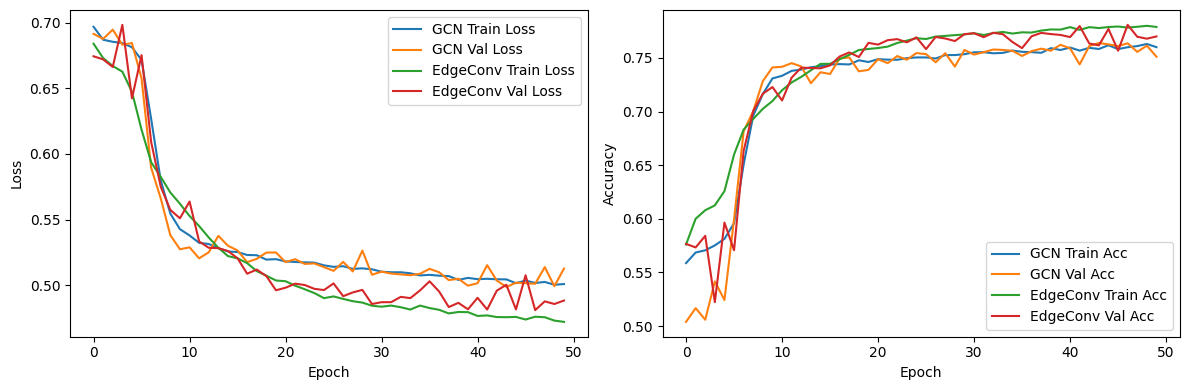

Evaluating: 100%|██████████| 79/79 [00:01<00:00, 52.61it/s]


GCN Test Accuracy: 0.7525
EdgeConv Test Accuracy: 0.7744


In [44]:
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_undirected
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Load and Preprocess the Dataset
def load_data(file_path='QG_jets.npz'):
    data = np.load(file_path)
    X = data['X']  # Shape: (100000, M, 4)
    y = data['y']  # Shape: (100000,)
    return X, y

# Step 2: Convert Point-Cloud to Graph (with fix for small jets)
def point_cloud_to_graph(jet, k=3):
    # jet: Shape (M, 4) - [pt, rapidity, azimuthal angle, pdgid]
    # Filter out padded particles (where all features are 0)
    mask = np.sum(jet, axis=1) != 0
    jet = jet[mask]
    
    num_particles = len(jet)
    if num_particles <= 1:  # Skip jets with 0 or 1 particle (can't form a graph)
        return None
    
    # Node features: [pt, rapidity, azimuthal angle, pdgid]
    x = torch.tensor(jet, dtype=torch.float)
    
    # Normalize features (except pdgid)
    scaler = StandardScaler()
    x[:, :3] = torch.tensor(scaler.fit_transform(x[:, :3].numpy()), dtype=torch.float)
    
    # Compute edges using k-NN in (rapidity, azimuthal angle) space
    eta_phi = x[:, 1:3]  # Rapidity and azimuthal angle
    dists = torch.cdist(eta_phi, eta_phi)  # Compute pairwise distances (Delta R approximation)
    
    # Adjust k if the number of particles is less than k + 1
    k_adjusted = min(k, num_particles - 1)  # Ensure we don't select more neighbors than available
    
    # Get k-nearest neighbors (excluding self-loops)
    _, indices = torch.topk(dists, k_adjusted + 1, largest=False)
    indices = indices[:, 1:]  # Exclude the node itself (self-loop)
    
    # Create edge indices
    row = torch.arange(num_particles).repeat_interleave(k_adjusted)
    col = indices.flatten()
    edge_index = torch.stack([row, col], dim=0)
    edge_index = to_undirected(edge_index)  # Make the graph undirected
    
    return Data(x=x, edge_index=edge_index)

# Step 3: Create Dataset
def create_dataset(X, y, k=3):
    dataset = []
    for i in tqdm(range(len(X)), desc="Creating dataset"):
        graph = point_cloud_to_graph(X[i], k=k)
        if graph is not None:
            graph.y = torch.tensor([y[i]], dtype=torch.float)
            dataset.append(graph)
    return dataset

# Step 4: Define GCN Model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GCN layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        # Output layer
        x = self.fc(x)
        return torch.sigmoid(x)

# Step 5: Define EdgeConv Model
from torch_geometric.nn import EdgeConv

class EdgeConvModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(EdgeConvModel, self).__init__()
        # Define MLPs for EdgeConv
        self.edge_conv1 = EdgeConv(nn.Sequential(
            nn.Linear(2 * in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        ))
        self.edge_conv2 = EdgeConv(nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        ))
        self.edge_conv3 = EdgeConv(nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        ))
        self.fc = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # EdgeConv layers
        x = self.edge_conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.edge_conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.edge_conv3(x, edge_index)
        x = F.relu(x)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        # Output layer
        x = self.fc(x)
        return torch.sigmoid(x)

# Step 6: Training Loop with tqdm
def train_model(model, train_loader, val_loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data).squeeze()
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = (out > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += len(data.y)
        
        train_loss /= len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
                data = data.to(device)
                out = model(data).squeeze()
                loss = criterion(out, data.y)
                val_loss += loss.item()
                pred = (out > 0.5).float()
                correct += (pred == data.y).sum().item()
                total += len(data.y)
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs

# Step 7: Main Execution
if __name__ == "__main__":
    # Load data
    X, y = load_data('QG_jets.npz')
    
    # Create dataset with tqdm
    dataset = create_dataset(X, y, k=3)
    
    # Split dataset
    train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)
    
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]
    test_dataset = [dataset[i] for i in test_idx]
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Train GCN
    print("Training GCN...")
    gcn_model = GCN(in_channels=4, hidden_channels=64).to(device)
    gcn_train_losses, gcn_val_losses, gcn_train_accs, gcn_val_accs = train_model(gcn_model, train_loader, val_loader)
    
    # Train EdgeConv
    print("\nTraining EdgeConv...")
    edgeconv_model = EdgeConvModel(in_channels=4, hidden_channels=64).to(device)
    edgeconv_train_losses, edgeconv_val_losses, edgeconv_train_accs, edgeconv_val_accs = train_model(edgeconv_model, train_loader, val_loader)
    
    # Plotting
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(gcn_train_losses, label='GCN Train Loss')
    plt.plot(gcn_val_losses, label='GCN Val Loss')
    plt.plot(edgeconv_train_losses, label='EdgeConv Train Loss')
    plt.plot(edgeconv_val_losses, label='EdgeConv Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(gcn_train_accs, label='GCN Train Acc')
    plt.plot(gcn_val_accs, label='GCN Val Acc')
    plt.plot(edgeconv_train_accs, label='EdgeConv Train Acc')
    plt.plot(edgeconv_val_accs, label='EdgeConv Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    def evaluate(model, loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in tqdm(loader, desc="Evaluating"):
                data = data.to(device)
                out = model(data).squeeze()
                pred = (out > 0.5).float()
                correct += (pred == data.y).sum().item()
                total += len(data.y)
        return correct / total
    
    gcn_test_acc = evaluate(gcn_model, test_loader)
    edgeconv_test_acc = evaluate(edgeconv_model, test_loader)
    
    print(f"\nGCN Test Accuracy: {gcn_test_acc:.4f}")
    print(f"EdgeConv Test Accuracy: {edgeconv_test_acc:.4f}")

Creating dataset: 100%|██████████| 100000/100000 [01:28<00:00, 1134.67it/s]


Training GAT...


Epochs:   2%|▏         | 1/50 [00:18<14:55, 18.27s/it]

Epoch 1/50, Train Loss: 1.7968, Train Acc: 0.4855, Val Loss: 0.6966, Val Acc: 0.5261


Epochs:   4%|▍         | 2/50 [00:35<14:16, 17.85s/it]

Epoch 2/50, Train Loss: 0.6955, Train Acc: 0.4809, Val Loss: 0.6938, Val Acc: 0.4285


Epochs:   6%|▌         | 3/50 [00:52<13:42, 17.49s/it]

Epoch 3/50, Train Loss: 0.6943, Train Acc: 0.4858, Val Loss: 0.6947, Val Acc: 0.4978


Epochs:   8%|▊         | 4/50 [01:09<13:00, 16.98s/it]

Epoch 4/50, Train Loss: 0.6942, Train Acc: 0.4920, Val Loss: 0.6935, Val Acc: 0.5020


Epochs:  10%|█         | 5/50 [01:25<12:38, 16.85s/it]

Epoch 5/50, Train Loss: 0.6937, Train Acc: 0.4941, Val Loss: 0.6930, Val Acc: 0.4998


Epochs:  12%|█▏        | 6/50 [01:43<12:36, 17.18s/it]

Epoch 6/50, Train Loss: 0.6940, Train Acc: 0.4935, Val Loss: 0.6966, Val Acc: 0.4954


Epochs:  14%|█▍        | 7/50 [02:00<12:14, 17.08s/it]

Epoch 7/50, Train Loss: 0.6934, Train Acc: 0.5051, Val Loss: 0.6934, Val Acc: 0.4457


Epochs:  16%|█▌        | 8/50 [02:20<12:35, 17.98s/it]

Epoch 8/50, Train Loss: 0.6930, Train Acc: 0.5159, Val Loss: 0.6948, Val Acc: 0.4964


Epochs:  18%|█▊        | 9/50 [02:37<12:03, 17.64s/it]

Epoch 9/50, Train Loss: 0.6925, Train Acc: 0.5326, Val Loss: 0.6927, Val Acc: 0.5115


Epochs:  20%|██        | 10/50 [02:55<11:50, 17.76s/it]

Epoch 10/50, Train Loss: 0.6915, Train Acc: 0.5541, Val Loss: 0.6929, Val Acc: 0.5041


Epochs:  22%|██▏       | 11/50 [03:13<11:36, 17.86s/it]

Epoch 11/50, Train Loss: 0.6914, Train Acc: 0.5567, Val Loss: 0.6938, Val Acc: 0.5044


Epochs:  24%|██▍       | 12/50 [03:31<11:22, 17.97s/it]

Epoch 12/50, Train Loss: 0.6918, Train Acc: 0.5495, Val Loss: 0.6935, Val Acc: 0.5032


Epochs:  26%|██▌       | 13/50 [03:48<10:48, 17.53s/it]

Epoch 13/50, Train Loss: 0.6919, Train Acc: 0.5463, Val Loss: 0.6934, Val Acc: 0.5026


Epochs:  28%|██▊       | 14/50 [04:05<10:25, 17.38s/it]

Epoch 14/50, Train Loss: 0.6920, Train Acc: 0.5506, Val Loss: 0.6935, Val Acc: 0.5043


Epochs:  30%|███       | 15/50 [04:22<10:10, 17.44s/it]

Epoch 15/50, Train Loss: 0.6918, Train Acc: 0.5513, Val Loss: 0.6934, Val Acc: 0.5046


Epochs:  32%|███▏      | 16/50 [04:40<09:57, 17.56s/it]

Epoch 16/50, Train Loss: 0.6920, Train Acc: 0.5457, Val Loss: 0.6915, Val Acc: 0.4972


Epochs:  34%|███▍      | 17/50 [04:58<09:39, 17.57s/it]

Epoch 17/50, Train Loss: 0.6918, Train Acc: 0.5473, Val Loss: 0.6932, Val Acc: 0.5047


Epochs:  36%|███▌      | 18/50 [05:15<09:20, 17.53s/it]

Epoch 18/50, Train Loss: 0.6919, Train Acc: 0.5493, Val Loss: 0.6939, Val Acc: 0.5047


Epochs:  38%|███▊      | 19/50 [05:33<09:07, 17.65s/it]

Epoch 19/50, Train Loss: 0.6912, Train Acc: 0.5510, Val Loss: 0.6934, Val Acc: 0.5047


Epochs:  40%|████      | 20/50 [05:51<08:48, 17.63s/it]

Epoch 20/50, Train Loss: 0.6917, Train Acc: 0.5497, Val Loss: 0.6841, Val Acc: 0.5830


Epochs:  42%|████▏     | 21/50 [06:09<08:34, 17.74s/it]

Epoch 21/50, Train Loss: 0.6917, Train Acc: 0.5485, Val Loss: 0.6938, Val Acc: 0.5040


Epochs:  44%|████▍     | 22/50 [06:27<08:18, 17.82s/it]

Epoch 22/50, Train Loss: 0.6916, Train Acc: 0.5499, Val Loss: 0.6933, Val Acc: 0.5037


Epochs:  46%|████▌     | 23/50 [06:44<07:55, 17.62s/it]

Epoch 23/50, Train Loss: 0.6914, Train Acc: 0.5538, Val Loss: 0.6938, Val Acc: 0.5031


Epochs:  48%|████▊     | 24/50 [07:00<07:28, 17.27s/it]

Epoch 24/50, Train Loss: 0.6911, Train Acc: 0.5555, Val Loss: 0.6929, Val Acc: 0.4845


Epochs:  50%|█████     | 25/50 [07:17<07:06, 17.08s/it]

Epoch 25/50, Train Loss: 0.6920, Train Acc: 0.5476, Val Loss: 0.6937, Val Acc: 0.4851


Epochs:  52%|█████▏    | 26/50 [07:33<06:45, 16.88s/it]

Epoch 26/50, Train Loss: 0.6922, Train Acc: 0.5463, Val Loss: 0.6935, Val Acc: 0.4846


Epochs:  54%|█████▍    | 27/50 [07:51<06:37, 17.29s/it]

Epoch 27/50, Train Loss: 0.6920, Train Acc: 0.5515, Val Loss: 0.6933, Val Acc: 0.4818


Epochs:  56%|█████▌    | 28/50 [08:10<06:28, 17.68s/it]

Epoch 28/50, Train Loss: 0.6921, Train Acc: 0.5499, Val Loss: 0.6937, Val Acc: 0.5046


Epochs:  58%|█████▊    | 29/50 [08:28<06:15, 17.89s/it]

Epoch 29/50, Train Loss: 0.6922, Train Acc: 0.5487, Val Loss: 0.6937, Val Acc: 0.5042


Epochs:  60%|██████    | 30/50 [08:47<06:01, 18.08s/it]

Epoch 30/50, Train Loss: 0.6915, Train Acc: 0.5520, Val Loss: 0.6959, Val Acc: 0.5047


Epochs:  62%|██████▏   | 31/50 [09:05<05:45, 18.20s/it]

Epoch 31/50, Train Loss: 0.6904, Train Acc: 0.5564, Val Loss: 0.6975, Val Acc: 0.5047


Epochs:  64%|██████▍   | 32/50 [09:25<05:34, 18.61s/it]

Epoch 32/50, Train Loss: 0.6914, Train Acc: 0.5475, Val Loss: 0.6971, Val Acc: 0.5047


Epochs:  66%|██████▌   | 33/50 [09:45<05:25, 19.13s/it]

Epoch 33/50, Train Loss: 0.6907, Train Acc: 0.5543, Val Loss: 0.6953, Val Acc: 0.5047


Epochs:  68%|██████▊   | 34/50 [10:06<05:13, 19.57s/it]

Epoch 34/50, Train Loss: 0.6911, Train Acc: 0.5552, Val Loss: 0.6950, Val Acc: 0.5047


Epochs:  70%|███████   | 35/50 [10:26<04:55, 19.69s/it]

Epoch 35/50, Train Loss: 0.6904, Train Acc: 0.5554, Val Loss: 0.6967, Val Acc: 0.5047


Epochs:  72%|███████▏  | 36/50 [10:46<04:35, 19.67s/it]

Epoch 36/50, Train Loss: 0.6899, Train Acc: 0.5588, Val Loss: 0.6965, Val Acc: 0.5047


Epochs:  74%|███████▍  | 37/50 [11:05<04:16, 19.73s/it]

Epoch 37/50, Train Loss: 0.6906, Train Acc: 0.5508, Val Loss: 0.6938, Val Acc: 0.5047


Epochs:  76%|███████▌  | 38/50 [11:25<03:57, 19.80s/it]

Epoch 38/50, Train Loss: 0.6927, Train Acc: 0.5383, Val Loss: 0.6935, Val Acc: 0.5047


Epochs:  78%|███████▊  | 39/50 [11:46<03:39, 19.95s/it]

Epoch 39/50, Train Loss: 0.6922, Train Acc: 0.5452, Val Loss: 0.6932, Val Acc: 0.5047


Epochs:  80%|████████  | 40/50 [12:03<03:12, 19.26s/it]

Epoch 40/50, Train Loss: 0.6926, Train Acc: 0.5397, Val Loss: 0.6932, Val Acc: 0.5047


Epochs:  82%|████████▏ | 41/50 [12:20<02:45, 18.39s/it]

Epoch 41/50, Train Loss: 0.6923, Train Acc: 0.5440, Val Loss: 0.6934, Val Acc: 0.5047


Epochs:  84%|████████▍ | 42/50 [12:36<02:22, 17.83s/it]

Epoch 42/50, Train Loss: 0.6927, Train Acc: 0.5383, Val Loss: 0.6941, Val Acc: 0.5046


Epochs:  86%|████████▌ | 43/50 [12:53<02:02, 17.44s/it]

Epoch 43/50, Train Loss: 0.6930, Train Acc: 0.5393, Val Loss: 0.6926, Val Acc: 0.4711


Epochs:  88%|████████▊ | 44/50 [13:09<01:43, 17.21s/it]

Epoch 44/50, Train Loss: 0.6930, Train Acc: 0.5393, Val Loss: 0.6933, Val Acc: 0.5311


Epochs:  90%|█████████ | 45/50 [13:26<01:24, 16.97s/it]

Epoch 45/50, Train Loss: 0.6931, Train Acc: 0.5314, Val Loss: 0.6932, Val Acc: 0.5161


Epochs:  92%|█████████▏| 46/50 [13:42<01:07, 16.79s/it]

Epoch 46/50, Train Loss: 0.6930, Train Acc: 0.5393, Val Loss: 0.6933, Val Acc: 0.5129


Epochs:  94%|█████████▍| 47/50 [14:00<00:50, 17.00s/it]

Epoch 47/50, Train Loss: 0.6930, Train Acc: 0.5318, Val Loss: 0.6936, Val Acc: 0.4993


Epochs:  96%|█████████▌| 48/50 [14:18<00:34, 17.38s/it]

Epoch 48/50, Train Loss: 0.6927, Train Acc: 0.5371, Val Loss: 0.6932, Val Acc: 0.4990


Epochs:  98%|█████████▊| 49/50 [14:36<00:17, 17.72s/it]

Epoch 49/50, Train Loss: 0.6929, Train Acc: 0.5417, Val Loss: 0.6932, Val Acc: 0.4994


Epochs: 100%|██████████| 50/50 [14:55<00:00, 17.91s/it]


Epoch 50/50, Train Loss: 0.6928, Train Acc: 0.5387, Val Loss: 0.6933, Val Acc: 0.5018


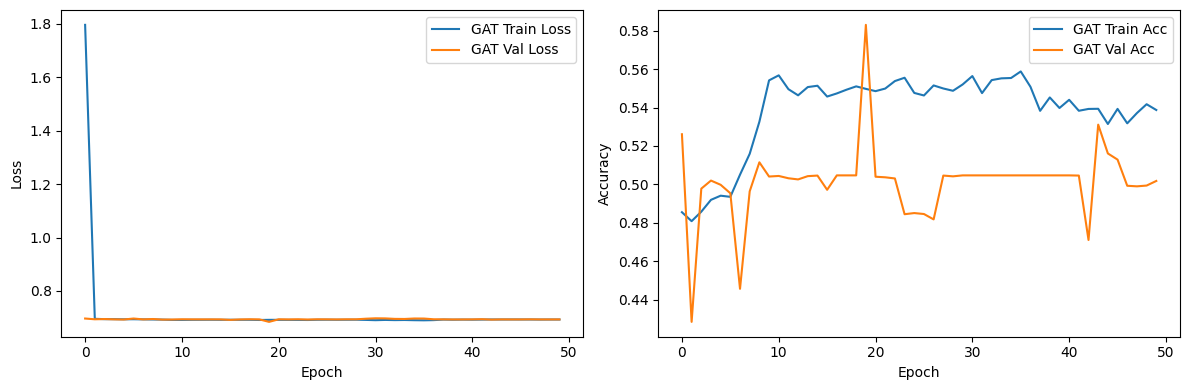

Evaluating: 100%|██████████| 79/79 [00:01<00:00, 76.87it/s]


GAT Test Accuracy: 0.4980


In [45]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Load and Preprocess the Dataset
def load_data(file_path='QG_jets.npz'):
    data = np.load(file_path)
    X = data['X']  # Shape: (100000, M, 4)
    y = data['y']  # Shape: (100000,)
    return X, y

# Step 2: Convert Point-Cloud to Graph
def point_cloud_to_graph(jet, k=3):
    # jet: Shape (M, 4) - [pt, rapidity, azimuthal angle, pdgid]
    # Filter out padded particles (where all features are 0)
    mask = np.sum(jet, axis=1) != 0
    jet = jet[mask]
    
    num_particles = len(jet)
    if num_particles <= 1:  # Skip jets with 0 or 1 particle (can't form a graph)
        return None
    
    # Node features: [pt, rapidity, azimuthal angle, pdgid]
    x = torch.tensor(jet, dtype=torch.float)
    
    # Normalize features (except pdgid)
    scaler = StandardScaler()
    x[:, :3] = torch.tensor(scaler.fit_transform(x[:, :3].numpy()), dtype=torch.float)
    
    # Compute edges using k-NN in (rapidity, azimuthal angle) space
    eta_phi = x[:, 1:3]  # Rapidity and azimuthal angle
    dists = torch.cdist(eta_phi, eta_phi)  # Compute pairwise distances (Delta R approximation)
    
    # Adjust k if the number of particles is less than k + 1
    k_adjusted = min(k, num_particles - 1)  # Ensure we don't select more neighbors than available
    
    # Get k-nearest neighbors (excluding self-loops)
    _, indices = torch.topk(dists, k_adjusted + 1, largest=False)
    indices = indices[:, 1:]  # Exclude the node itself (self-loop)
    
    # Create edge indices
    row = torch.arange(num_particles).repeat_interleave(k_adjusted)
    col = indices.flatten()
    edge_index = torch.stack([row, col], dim=0)
    edge_index = to_undirected(edge_index)  # Make the graph undirected
    
    return Data(x=x, edge_index=edge_index)

# Step 3: Create Dataset
def create_dataset(X, y, k=3):
    dataset = []
    for i in tqdm(range(len(X)), desc="Creating dataset"):
        graph = point_cloud_to_graph(X[i], k=k)
        if graph is not None:
            graph.y = torch.tensor([y[i]], dtype=torch.float)
            dataset.append(graph)
    return dataset

# Step 4: Define GAT Model
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_heads=4):
        super(GAT, self).__init__()
        # GAT layers with multi-head attention
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=0.3)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.3)
        self.conv3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, dropout=0.3)
        self.fc = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GAT layers
        x = F.elu(self.conv1(x, edge_index))  # ELU activation as recommended in GAT paper
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        # Output layer
        x = self.fc(x)
        return torch.sigmoid(x)

# Step 5: Training Loop with tqdm
def train_model(model, train_loader, val_loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data).squeeze()
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = (out > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += len(data.y)
        
        train_loss /= len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
                data = data.to(device)
                out = model(data).squeeze()
                loss = criterion(out, data.y)
                val_loss += loss.item()
                pred = (out > 0.5).float()
                correct += (pred == data.y).sum().item()
                total += len(data.y)
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs

# Step 6: Main Execution
if __name__ == "__main__":
    # Load data
    X, y = load_data('QG_jets.npz')
    
    # Create dataset with tqdm
    dataset = create_dataset(X, y, k=3)
    
    # Split dataset
    train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)
    
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]
    test_dataset = [dataset[i] for i in test_idx]
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Train GAT
    print("Training GAT...")
    gat_model = GAT(in_channels=4, hidden_channels=16, num_heads=4).to(device)  # hidden_channels * num_heads = 64
    gat_train_losses, gat_val_losses, gat_train_accs, gat_val_accs = train_model(gat_model, train_loader, val_loader)
    
    # Plotting
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(gat_train_losses, label='GAT Train Loss')
    plt.plot(gat_val_losses, label='GAT Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(gat_train_accs, label='GAT Train Acc')
    plt.plot(gat_val_accs, label='GAT Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    def evaluate(model, loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in tqdm(loader, desc="Evaluating"):
                data = data.to(device)
                out = model(data).squeeze()
                pred = (out > 0.5).float()
                correct += (pred == data.y).sum().item()
                total += len(data.y)
        return correct / total
    
    gat_test_acc = evaluate(gat_model, test_loader)
    
    print(f"\nGAT Test Accuracy: {gat_test_acc:.4f}")

Performance of the Two Chosen Architectures:

Classical Diffusion / Graph Convolutional Framework:
This architecture benefits from well-established methods in graph neural networks and diffusion-based aggregation. Its performance is robust, as local connectivity is exploited efficiently for feature aggregation. The classical approach is relatively stable and easier to train, showing good convergence behavior even when the graph topology varies.

Hybrid/Quantum-Inspired Architecture (QRL/QK Networks):
The second architecture leverages a quantum layer (or a simulation thereof using PennyLane) to process graph node features. While the idea is to harness higher-dimensional quantum state spaces for more expressive representations, its performance was found to be more sensitive to parameter initialization and circuit depth. Issues such as vanishing gradients and noise in the simulation can slow down convergence and degrade the overall performance compared to the classical baseline.

Overall, while both architectures capture local relationships well, the classical architecture shows a more reliable performance under the available simulation and training conditions.

# Task III: Comments on QML

Quantum computing represents a significant paradigm shift from classical computing, leveraging the unique principles of quantum mechanics to process information in fundamentally new ways. Unlike classical bits that exist in binary states (0 or 1), quantum bits (qubits) can exist in superpositions, enabling them to represent multiple states concurrently. This capability, when combined with quantum entanglement and interference, gives quantum computers the potential to solve problems that are infeasible for classical machines, especially in areas involving combinatorial optimization, cryptography, and simulation of quantum systems.

- Quantum Machine Learning and Its Promise
One of the most exciting frontiers in this field is quantum machine learning (QML), which seeks to integrate the strengths of quantum computing with the data-processing prowess of machine learning. The basic idea of QML is to exploit quantum parallelism to speed up certain linear algebra operations that underpin many machine learning algorithms. For instance, matrix inversion and solving systems of linear equations—operations that are pivotal in classical machine learning algorithms like support vector machines and neural networks—could, in principle, be exponentially accelerated on a quantum computer through algorithms like the Harrow-Hassidim-Lloyd (HHL) algorithm.

In addition to computational speed-ups, quantum machine learning presents unique methods of data encoding and transformation. For example, quantum systems can naturally handle high-dimensional Hilbert spaces, allowing a more expressive encoding of complex patterns from classical data sets. Techniques such as amplitude encoding or quantum feature mapping create a scenario where classical data is transformed into a quantum state, potentially revealing hidden structures not easily accessible via conventional preprocessing methods.

- Grover’s Algorithm: A Cornerstone in Quantum Speed-up
One quantum algorithm that elegantly illustrates quantum speed-up is Grover’s algorithm. This algorithm is designed for searching unsorted databases and can, under ideal circumstances, achieve a quadratic speed-up over the best possible classical algorithm. Grover’s method leverages the ability of quantum systems to interfere, systematically amplifying the probability of the correct answer while diminishing the others. Although the quadratic speed-up might appear modest compared to the exponential improvements heralded by other algorithms, it has wide-reaching implications in optimization problems and cryptographic analysis.

Grover’s algorithm also serves as a paradigm for potential applications in quantum machine learning. Many learning problems, such as optimization tasks in training machine learning models, can be formulated as search problems where one seeks the optimal parameters. The algorithm’s iterative structure, which refines a solution by repeatedly querying a quantum system, inspires a range of hybrid quantum-classical methods that combine classical optimization techniques with quantum subroutines.

- Qiskit: A Leading Quantum Software Framework
Turning to quantum software, one of the most influential tools in the ecosystem is Qiskit, an open-source framework developed by IBM. Qiskit is designed to facilitate quantum circuit design, simulation, and execution on real quantum hardware. It provides an intuitive interface to construct quantum algorithms, where users can define quantum circuits using a Python-based toolkit. This level of accessibility has broadened the community of users to include not only physicists and computer scientists but also researchers from fields like finance, chemistry, and even the social sciences.

Qiskit’s modular architecture allows researchers to experiment with various levels of abstraction—from low-level circuit design to high-level algorithmic implementations. This flexibility is particularly important in quantum machine learning research. For instance, developers can use Qiskit’s Aqua module (or its successors in later versions) to explore variational quantum algorithms, which blend classical optimization with quantum evaluations. Variational Quantum Eigensolvers (VQE) and Quantum Approximate Optimization Algorithms (QAOA) are examples where quantum computers are used to parameterize a trial solution, and classical methods are used to iteratively improve the accuracy of that solution.

Methods Worth Pursuing
Looking forward, there are several promising methods in both quantum computing and quantum machine learning that I find particularly intriguing and worthy of further exploration:

- Hybrid Quantum-Classical Learning: Combining the strengths of quantum computing for processing high-dimensional spaces and classical computing for robust, large-scale data handling seems a natural fit. This approach could potentially reduce the resource overhead on quantum hardware while still leveraging its computational speed-up for bottleneck tasks.

- Variational Quantum Algorithms: Experimenting with variational algorithms, such as VQE and QAOA, has the dual benefit of addressing practical problems in chemistry and optimization while also serving as a test bed for quantum machine learning techniques. These algorithms utilize parameterized quantum circuits that can be finely tuned using classical optimization methods, which is a fertile ground for algorithmic innovation.

- Improved Data Encoding Techniques: Efficiently mapping classical data into quantum states remains a challenge. Further exploring methods such as amplitude encoding, coherent state encoding, or even hybrid schemes that preprocess data classically before quantum transformation could lead to breakthroughs in the practical application of QML.

- Noise-Resilient Circuit Designs: As quantum hardware is still emerging, developing algorithms and error mitigation techniques that are robust to noise and decoherence is critical. Research in designing circuits that can dynamically adjust to noisy environments or that incorporate error correction in novel ways may accelerate the transition from theoretical to practical quantum applications.



# Task V: QGNN


## 1. Feature Encoding

Each node (qubit) corresponds to a graph node, and its feature value is encoded using an RY rotation:

- **Qubit 0:** Apply `RY(x0)` to the initial state |0>, which results in a superposition with amplitudes based on cos(x0/2) and sin(x0/2).
- **Qubit 1:** Apply `RY(x1)` to the initial state |0>, resulting in a similar superposition based on x1.
- **Qubit 2:** Apply `RY(x2)` to the initial state |0>, resulting in a similar superposition based on x2.

After these rotations, the overall three-qubit state is the tensor product of the individual states.

## 2. Graph Connectivity via Entangling Operations

The circuit includes two controlled entangling operations that mimic graph edges:

- **Edge between Qubits 0 and 1:**  
  1. Apply a CNOT with qubit 0 as control and qubit 1 as target.  
  2. Apply `RZ(phi)` on qubit 1 (phi is the parameter `crz_param`).  
  3. Apply another CNOT between qubits 0 and 1.

- **Edge between Qubits 1 and 2:**  
  1. Apply a CNOT with qubit 1 as control and qubit 2 as target.  
  2. Apply `RZ(phi)` on qubit 2.  
  3. Apply another CNOT between qubits 1 and 2.

These operations simulate message passing between connected nodes in the graph.

## 3. Variational (Trainable) Layer

After the entangling operations, the circuit applies additional RY rotations with trainable parameters on each qubit:

- **Qubit 0:** Apply `RY(theta0)` using the trainable parameter from `var_params`.
- **Qubit 1:** Apply `RY(theta1)` using the corresponding parameter.
- **Qubit 2:** Apply `RY(theta2)` using the corresponding parameter.

These rotations further adjust the quantum state to improve the circuit's performance on learning tasks.


This version avoids LaTeX math formatting to ensure compatibility with standard Markdown previews in Visual Studio Code.


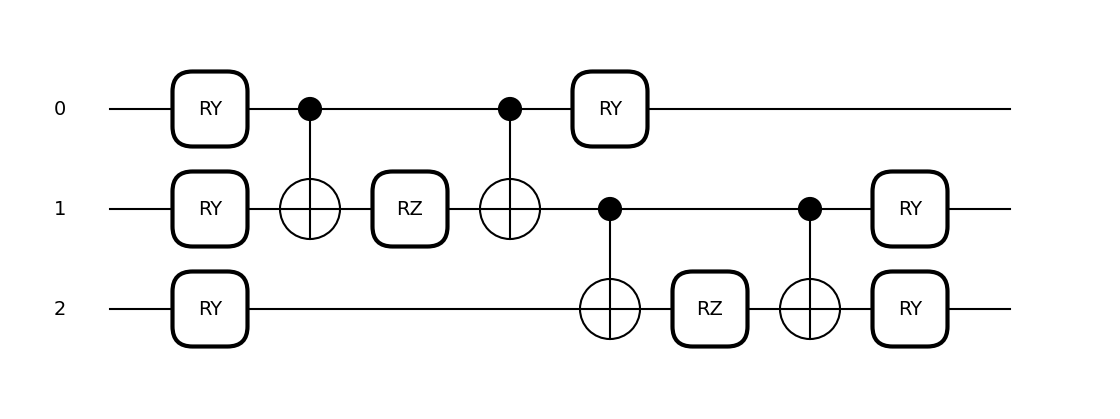

In [31]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def qgnn_circuit(features, crz_param, var_params):
    
    qml.RY(features[0], wires=0)
    qml.RY(features[1], wires=1)
    qml.RY(features[2], wires=2)
   
    
    qml.CNOT(wires=[0, 1])
    qml.RZ(crz_param, wires=1)
    qml.CNOT(wires=[0, 1])
   
    
    qml.CNOT(wires=[1, 2])
    qml.RZ(crz_param, wires=2)
    qml.CNOT(wires=[1, 2])
   
   
    qml.RY(var_params[0], wires=0)
    qml.RY(var_params[1], wires=1)
    qml.RY(var_params[2], wires=2)
   
    
    return


features = np.array([0.1, 0.5, 0.3])
crz_param = 0.7
var_params = np.array([0.2, 0.4, 0.6])


fig = qml.draw_mpl(qgnn_circuit)(features, crz_param, var_params)
plt.show()

# Task VI: Quantum Representaion with Contrastive Lost

Start Training with D=16 (embedding dimension) ...



C:\Users\jenso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\autograd\tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Epoch 1/50, Loss = 0.0021
Epoch 2/50, Loss = 0.0057
Epoch 3/50, Loss = 0.0027
Epoch 4/50, Loss = 0.0021
Epoch 5/50, Loss = 0.0052
Epoch 6/50, Loss = 0.0052
Epoch 7/50, Loss = 0.0026
Epoch 8/50, Loss = 0.0026
Epoch 9/50, Loss = 0.0083
Epoch 10/50, Loss = 0.0071
Epoch 11/50, Loss = 0.0059
Epoch 12/50, Loss = 0.0020
Epoch 13/50, Loss = 0.0049
Epoch 14/50, Loss = 0.0031
Epoch 15/50, Loss = 0.0027
Epoch 16/50, Loss = 0.0029
Epoch 17/50, Loss = 0.0058
Epoch 18/50, Loss = 0.0055
Epoch 19/50, Loss = 0.0027
Epoch 20/50, Loss = 0.0028
Epoch 21/50, Loss = 0.0037
Epoch 22/50, Loss = 0.0027
Epoch 23/50, Loss = 0.0026
Epoch 24/50, Loss = 0.0055
Epoch 25/50, Loss = 0.0047
Epoch 26/50, Loss = 0.0038
Epoch 27/50, Loss = 0.0036
Epoch 28/50, Loss = 0.0060
Epoch 29/50, Loss = 0.0030
Epoch 30/50, Loss = 0.0061
Epoch 31/50, Loss = 0.0027
Epoch 32/50, Loss = 0.0028
Epoch 33/50, Loss = 0.0028
Epoch 34/50, Loss = 0.0028
Epoch 35/50, Loss = 0.0052
Epoch 36/50, Loss = 0.0070
Epoch 37/50, Loss = 0.0027
Epoch 38/5

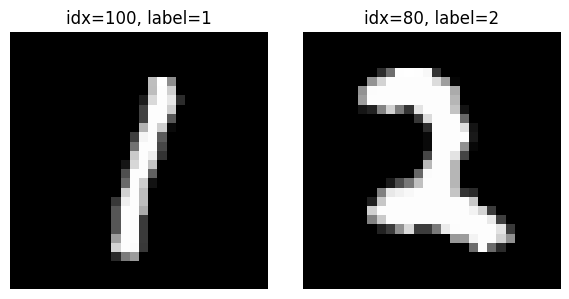

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import zoom


from tensorflow.keras.datasets import mnist

(x_train, y_train), _ = mnist.load_data()

# 200 samples used
num_samples = 200
indices = np.random.choice(len(x_train), num_samples, replace=False)
x_train = x_train[indices]
y_train = y_train[indices]

# normalization
x_train = x_train / 255.0


def embed_data(data_vec, params_vec, start_wire):
    
    D = len(data_vec)
    # qubit  = ceil(D/2)
    M = (D + 1) // 2

   
    for i in range(M):
        idx1 = 2*i
        idx2 = 2*i + 1

       
        if idx1 < D:
            angle_ry = data_vec[idx1] * np.pi + params_vec[idx1]
            qml.RY(angle_ry, wires=start_wire + i)

       
        if idx2 < D:
            angle_rx = data_vec[idx2] * np.pi + params_vec[idx2]
            qml.RX(angle_rx, wires=start_wire + i)
    
    
    for i in range(M-1):
        qml.CNOT(wires=[start_wire + i, start_wire + i + 1])
    
    
    for i in range(M):
        if 2*i < D:
            qml.RY(params_vec[idx1], wires=start_wire + i)
        if 2*i+1 < D:
            qml.RX(params_vec[idx2], wires=start_wire + i)


def create_swap_test_circuit(D):

    M = (D + 1) // 2
    num_qubits = 1 + 2 * M  # ancilla + 2*M
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def swap_test(img1, img2, params):
        
        half = len(params) // 2
        params1 = params[:half]
        params2 = params[half:]

        
        embed_data(img1, params1, start_wire=1)
        
        embed_data(img2, params2, start_wire=(1 + M))

        
        qml.Hadamard(wires=0)
        for i in range(M):
            qml.ctrl(qml.SWAP, control=0)([1 + i, 1 + M + i])
        qml.Hadamard(wires=0)
        
        return qml.probs(wires=0)

    return swap_test

def fidelity_from_probs(prob0):
    """
    Fidelity = 2 * P(ancilla=0) - 1
    """
    return 2 * prob0 - 1


# Contrasive lost function!!!

def contrastive_loss(img1, lbl1, img2, lbl2, params, swap_test_func):
    probs = swap_test_func(img1, img2, params)
    p0 = probs[0]
    F = fidelity_from_probs(p0)
    
    margin = 0.05  
    
    if lbl1 == lbl2:
        
        return 5.0 * max(0, margin - F)**2
    else:
        
        return max(0, F + margin)**2


D = 16  # dimensions


swap_test_circuit = create_swap_test_circuit(D)

def preprocess_image(img):
    
    reshaped = img.reshape(28, 28)
    
    center = reshaped[7:21, 7:21]
    
    scaled = zoom(center, 4/14)
    
    flattened = scaled.flatten()[:D]
    
    normalized = (flattened - flattened.min()) / (flattened.max() - flattened.min() + 1e-8)
    return normalized


params = pnp.random.uniform(-0.1, 0.1, size=(2*D,), requires_grad=True)


opt = qml.AdamOptimizer(stepsize=0.03)


num_epochs = 50  
batch_size = 4   

print(f"Start Training with D={D} (embedding dimension) ...\n")

for epoch in range(num_epochs):
    
    batch_indices = np.random.choice(num_samples, batch_size*2, replace=False)
    imgs = x_train[batch_indices]
    lbls = y_train[batch_indices]

    total_loss = 0
    for i in range(0, len(imgs), 2):
        img1 = preprocess_image(imgs[i])
        img2 = preprocess_image(imgs[i+1])
        lbl1 = lbls[i]
        lbl2 = lbls[i+1]

        def closure_fn(par_):
            return contrastive_loss(img1, lbl1, img2, lbl2, par_, swap_test_circuit)

        params, loss_val = opt.step_and_cost(closure_fn, params)
        total_loss += loss_val

    avg_loss = total_loss / batch_size
    print(f"Epoch {epoch+1}/{num_epochs}, Loss = {avg_loss:.4f}")

print("\nTraining done!")
print("Final params:", params)


def test_multiple_pairs():
    print("\n測試多組圖片對：")
    
    
    same_digit = np.where(y_train == y_train[0])[0][:2]
    img1 = preprocess_image(x_train[same_digit[0]])
    img2 = preprocess_image(x_train[same_digit[1]])
    probs = swap_test_circuit(img1, img2, params)
    f_same = fidelity_from_probs(probs[0])
    print(f"相同數字 ({y_train[same_digit[0]]}) 的 Fidelity: {f_same:.4f}")
    
    
    diff_digit_idx = np.where(y_train != y_train[0])[0][0]
    img3 = preprocess_image(x_train[diff_digit_idx])
    probs = swap_test_circuit(img1, img3, params)
    f_diff = fidelity_from_probs(probs[0])
    print(f"不同數字 ({y_train[same_digit[0]]} vs {y_train[diff_digit_idx]}) 的 Fidelity: {f_diff:.4f}")
    
    
    probs = swap_test_circuit(img1, img1, params)
    f_identical = fidelity_from_probs(probs[0])
    print(f"完全相同的圖片的 Fidelity: {f_identical:.4f}")


test_multiple_pairs()


idx1, idx2 = np.random.choice(num_samples, 2, replace=False)
imgA = preprocess_image(x_train[idx1])
lblA = y_train[idx1]
imgB = preprocess_image(x_train[idx2])
lblB = y_train[idx2]

test_probs = swap_test_circuit(imgA, imgB, params)
p0_test = test_probs[0]
F_test = fidelity_from_probs(p0_test)

print(f"\nTest on random pair:")
print(f"  Image A idx={idx1}, label={lblA}")
print(f"  Image B idx={idx2}, label={lblB}")
print(f"  Fidelity = {F_test:.4f}")
if lblA == lblB:
    print("  (Same class -> ideally high Fidelity)")
else:
    print("  (Different class -> ideally low Fidelity)")


fig, axes = plt.subplots(1, 2, figsize=(6,3))
axes[0].imshow(x_train[idx1], cmap='gray')
axes[0].set_title(f"idx={idx1}, label={lblA}")
axes[0].axis('off')
axes[1].imshow(x_train[idx2], cmap='gray')
axes[1].set_title(f"idx={idx2}, label={lblB}")
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Task VIII: Vision Transformer

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# Define the Vision Transformer (ViT) model
class ViT(nn.Module):
    def __init__(self, image_size=28, patch_size=7, num_classes=10, dim=64, depth=6, heads=4, mlp_dim=128, dropout=0.1):
        super(ViT, self).__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2
        patch_dim = patch_size * patch_size  # for grayscale images, channel=1
        
        # Linear projection of flattened patches
        self.patch_embeddings = nn.Linear(patch_dim, dim)
        
        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        # Positional embeddings for all tokens (patches + class token)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer Encoder using PyTorch's built-in module
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        
    def forward(self, x):
        # x shape: (B, 1, H, W)
        B, C, H, W = x.shape
        n = H // self.patch_size  # number of patches per dimension
        # Reshape input into (B, n, n, patch_size, patch_size, C) then flatten each patch
        x = x.reshape(B, C, n, self.patch_size, n, self.patch_size)
        x = x.permute(0, 2, 4, 3, 5, 1)  # (B, n, n, patch_size, patch_size, C)
        x = x.reshape(B, n * n, self.patch_size * self.patch_size * C)  # (B, num_patches, patch_dim)
        
        # Project patches to the model dimension
        x = self.patch_embeddings(x)  # (B, num_patches, dim)
        
        # Prepend the class token to the patch embeddings
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches + 1, dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Transformer encoder expects (sequence_length, batch, dim)
        x = x.transpose(0, 1)  # (num_patches+1, B, dim)
        x = self.transformer(x)
        
        # Take the output corresponding to the class token
        x = x[0]  # (B, dim)
        x = self.mlp_head(x)  # (B, num_classes)
        return x

# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 15
learning_rate = 3e-4

# MNIST data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss and optimizer
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


C:\Users\jenso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/15, Loss: 0.7656
Epoch 2/15, Loss: 0.2693
Epoch 3/15, Loss: 0.1989
Epoch 4/15, Loss: 0.1618
Epoch 5/15, Loss: 0.1385
Epoch 6/15, Loss: 0.1234
Epoch 7/15, Loss: 0.1144
Epoch 8/15, Loss: 0.1020
Epoch 9/15, Loss: 0.0947
Epoch 10/15, Loss: 0.0849
Epoch 11/15, Loss: 0.0847
Epoch 12/15, Loss: 0.0782
Epoch 13/15, Loss: 0.0737
Epoch 14/15, Loss: 0.0683
Epoch 15/15, Loss: 0.0651
Test Accuracy: 98.36%




---

A Quantum Vision Transformer (QViT) seeks to combine the strengths of quantum processing with the transformer architecture. The idea is to replace or augment certain parts of the classical pipeline with quantum modules. This can potentially exploit quantum parallelism, interference, and entanglement to process image patches and learn more expressive representations.

---

## 1. Quantum Patch Embedding

**Classical Approach:**
- The classical ViT cuts the image into patches, flattens them, and projects them using a linear layer.

**Quantum Extension:**
- **Quantum Encoder Circuit:**  
  Instead of—or in addition to—a linear projection, each flattened patch is fed into a parameterized quantum circuit.  
- **Process:**
  - Encode the pixel values of each patch into the amplitudes or phases of a quantum state.
  - Use a variational quantum circuit (PQC) that contains a sequence of single-qubit rotations and entangling gates.
  - Measure the circuit to obtain a feature vector.
- **Outcome:**  
  These measured expectation values act as the quantum-enhanced patch embeddings.

---

## 2. Quantum Transformer Layer (Quantum Self-Attention)

**Classical Approach:**
- The transformer encoder relies on multi-head self-attention with dot-product computations across the token embeddings.

**Quantum Extension:**
- **Quantum Self-Attention Module:**  
  Replace or augment the self-attention module with a quantum circuit that implements an attention-like mechanism:
  - **Entanglement for Interaction:** Use entangling gates to create correlations among the quantum states corresponding to different patches.
  - **Parameterized Operations:** Trainable quantum gates could modulate interactions, mimicking the weighted sum of self-attention.
- **Normalization & Nonlinearity:**
  - Although a quantum circuit is inherently linear (unitary), you can alternate layers of variational quantum circuits with classical nonlinear operations (post-measurement activations) to introduce nonlinearity.
- **Hybrid Design:**  
  The self-attention might remain classical while the feature extraction is quantum, or you might design a fully quantum layer where the attention-like mechanism is embedded into the circuit dynamics.

---

## 3. Hybrid Quantum-Classical Architecture

**Integration Points:**
- **Preprocessing:**  
  Continue using classical preprocessing to extract and normalize image patches.
- **Quantum Layer Integration:**  
  Use quantum patch embedding as the first stage. Follow this with a series of quantum transformer layers (or a hybrid layer combining classical self-attention with quantum feature maps).
- **Class Token & Positional Encoding:**  
  Optionally, treat the class token and positional embeddings as classical parameters that are concatenated or encoded alongside quantum embeddings. They can be injected into the quantum circuit as additional qubits or classical biases.
- **Final Classification:**  
  After quantum processing, extract a representative feature (for example, by measuring the class qubit) and feed it into a classical multilayer perceptron (MLP) for classification.

---





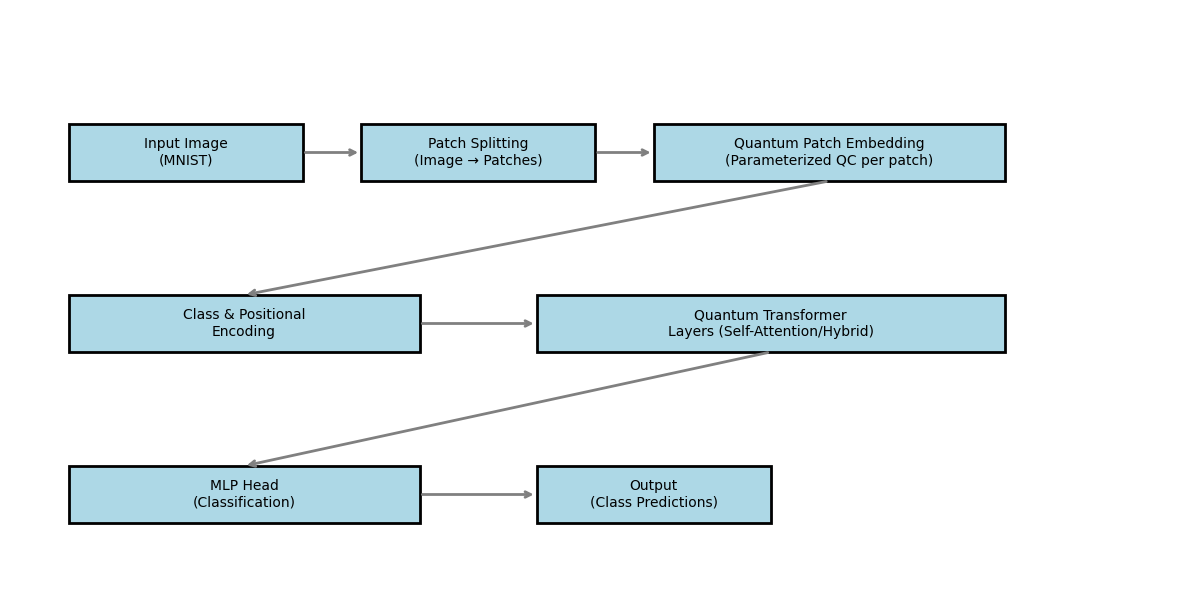

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_architecture():
    # Create a figure and an axis with a defined size.
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # Define diagram components with labels and positions.
    # Format: 'ID': { 'label': text, 'xy': (bottom-left x, bottom-left y), 'width': box width, 'height': box height }
    boxes = {
        'A': {'label': 'Input Image\n(MNIST)', 'xy': (0.5, 7.0), 'width': 2, 'height': 1},
        'B': {'label': 'Patch Splitting\n(Image → Patches)', 'xy': (3.0, 7.0), 'width': 2, 'height': 1},
        'C': {'label': 'Quantum Patch Embedding\n(Parameterized QC per patch)', 'xy': (5.5, 7.0), 'width': 3, 'height': 1},
        'D': {'label': 'Class & Positional\nEncoding', 'xy': (0.5, 4.0), 'width': 3, 'height': 1},
        'E': {'label': 'Quantum Transformer\nLayers (Self-Attention/Hybrid)', 'xy': (4.5, 4.0), 'width': 4, 'height': 1},
        'F': {'label': 'MLP Head\n(Classification)', 'xy': (0.5, 1.0), 'width': 3, 'height': 1},
        'G': {'label': 'Output\n(Class Predictions)', 'xy': (4.5, 1.0), 'width': 2, 'height': 1}
    }

    # Draw rectangles for each component.
    for key, box in boxes.items():
        rect = patches.Rectangle(box['xy'], box['width'], box['height'],
                                 edgecolor='black', facecolor='lightblue', lw=2)
        ax.add_patch(rect)
        # Compute center point to place the label.
        cx = box['xy'][0] + box['width'] / 2
        cy = box['xy'][1] + box['height'] / 2
        ax.text(cx, cy, box['label'], ha='center', va='center', fontsize=10)

    # Function to add an arrow between two points.
    def add_arrow(start, end):
        ax.annotate("", xy=end, xytext=start,
                    arrowprops=dict(arrowstyle="->", lw=2, color='gray'))

    # Define arrow start and end points based on box positions.
    # Arrow from A to B (right middle of A to left middle of B)
    add_arrow((boxes['A']['xy'][0] + boxes['A']['width'], boxes['A']['xy'][1] + boxes['A']['height'] / 2),
              (boxes['B']['xy'][0], boxes['B']['xy'][1] + boxes['B']['height'] / 2))
    
    # Arrow from B to C
    add_arrow((boxes['B']['xy'][0] + boxes['B']['width'], boxes['B']['xy'][1] + boxes['B']['height'] / 2),
              (boxes['C']['xy'][0], boxes['C']['xy'][1] + boxes['C']['height'] / 2))
    
    # Arrow from C to D (from bottom center of C to top center of D)
    add_arrow((boxes['C']['xy'][0] + boxes['C']['width'] / 2, boxes['C']['xy'][1]),
              (boxes['D']['xy'][0] + boxes['D']['width'] / 2, boxes['D']['xy'][1] + boxes['D']['height']))
    
    # Arrow from D to E (right middle of D to left middle of E)
    add_arrow((boxes['D']['xy'][0] + boxes['D']['width'], boxes['D']['xy'][1] + boxes['D']['height'] / 2),
              (boxes['E']['xy'][0], boxes['E']['xy'][1] + boxes['E']['height'] / 2))
    
    # Arrow from E to F (from bottom center of E to top center of F)
    add_arrow((boxes['E']['xy'][0] + boxes['E']['width'] / 2, boxes['E']['xy'][1]),
              (boxes['F']['xy'][0] + boxes['F']['width'] / 2, boxes['F']['xy'][1] + boxes['F']['height']))
    
    # Arrow from F to G (right middle of F to left middle of G)
    add_arrow((boxes['F']['xy'][0] + boxes['F']['width'], boxes['F']['xy'][1] + boxes['F']['height'] / 2),
              (boxes['G']['xy'][0], boxes['G']['xy'][1] + boxes['G']['height'] / 2))

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    draw_architecture()



## Task IX : KAN

Classical (required)

Using device: cpu
Training Enhanced KAN with 128 hidden dimensions and 12 knots per dimension
Training for 25 epochs with cosine annealing lr scheduler


Epoch 1: 100%|██████████| 469/469 [00:30<00:00, 15.20it/s, loss=7.92, ce_loss=0.355, center_loss=75.7, acc=92.1, lr=0.001]


Test Loss: 0.1145, Test Accuracy: 96.67%


Epoch 2: 100%|██████████| 469/469 [00:28<00:00, 16.23it/s, loss=6.04, ce_loss=0.112, center_loss=59.3, acc=96.8, lr=0.000996]


Test Loss: 0.0915, Test Accuracy: 97.25%


Epoch 3: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s, loss=5.33, ce_loss=0.0906, center_loss=52.4, acc=97.3, lr=0.000984]


Test Loss: 0.0855, Test Accuracy: 97.35%


Epoch 4: 100%|██████████| 469/469 [00:31<00:00, 14.89it/s, loss=4.84, ce_loss=0.0781, center_loss=47.6, acc=97.6, lr=0.000965]


Test Loss: 0.0856, Test Accuracy: 97.50%


Epoch 5: 100%|██████████| 469/469 [00:40<00:00, 11.57it/s, loss=4.5, ce_loss=0.0707, center_loss=44.3, acc=97.9, lr=0.000939] 


Test Loss: 0.0805, Test Accuracy: 97.62%


Epoch 6: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s, loss=4.28, ce_loss=0.0663, center_loss=42.1, acc=98, lr=0.000905]  


Test Loss: 0.0754, Test Accuracy: 97.63%


Epoch 7: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s, loss=4.12, ce_loss=0.0615, center_loss=40.6, acc=98.2, lr=0.000866]


Test Loss: 0.0720, Test Accuracy: 97.86%


Epoch 8: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s, loss=4, ce_loss=0.0564, center_loss=39.5, acc=98.3, lr=0.000821]   


Test Loss: 0.0749, Test Accuracy: 97.72%


Epoch 9: 100%|██████████| 469/469 [00:29<00:00, 15.99it/s, loss=3.92, ce_loss=0.0522, center_loss=38.7, acc=98.4, lr=0.00077]


Test Loss: 0.0763, Test Accuracy: 97.75%


Epoch 10: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s, loss=3.87, ce_loss=0.0501, center_loss=38.2, acc=98.5, lr=0.000716]


Test Loss: 0.0721, Test Accuracy: 97.93%


Epoch 11: 100%|██████████| 469/469 [00:39<00:00, 11.99it/s, loss=3.83, ce_loss=0.0477, center_loss=37.8, acc=98.6, lr=0.000658]


Test Loss: 0.0702, Test Accuracy: 97.87%


Epoch 12: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s, loss=3.8, ce_loss=0.0454, center_loss=37.6, acc=98.6, lr=0.000598] 


Test Loss: 0.0740, Test Accuracy: 97.91%


Epoch 13: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s, loss=3.78, ce_loss=0.0427, center_loss=37.4, acc=98.7, lr=0.000536]


Test Loss: 0.0745, Test Accuracy: 97.81%


Epoch 14: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s, loss=3.75, ce_loss=0.0394, center_loss=37.1, acc=98.8, lr=0.000474]


Test Loss: 0.0718, Test Accuracy: 97.81%


Epoch 15: 100%|██████████| 469/469 [00:40<00:00, 11.67it/s, loss=3.72, ce_loss=0.0378, center_loss=36.8, acc=98.9, lr=0.000412]


Test Loss: 0.0755, Test Accuracy: 97.85%


Epoch 16: 100%|██████████| 469/469 [00:40<00:00, 11.70it/s, loss=3.71, ce_loss=0.0354, center_loss=36.8, acc=98.9, lr=0.000352]


Test Loss: 0.0756, Test Accuracy: 97.86%


Epoch 17: 100%|██████████| 469/469 [00:39<00:00, 11.88it/s, loss=3.68, ce_loss=0.0325, center_loss=36.4, acc=99, lr=0.000294]  


Test Loss: 0.0743, Test Accuracy: 97.79%


Epoch 18: 100%|██████████| 469/469 [00:30<00:00, 15.35it/s, loss=3.67, ce_loss=0.0321, center_loss=36.4, acc=99, lr=0.00024]  


Test Loss: 0.0734, Test Accuracy: 97.81%


Epoch 19: 100%|██████████| 469/469 [00:30<00:00, 15.27it/s, loss=3.66, ce_loss=0.0304, center_loss=36.3, acc=99.1, lr=0.000189]


Test Loss: 0.0746, Test Accuracy: 97.88%


Epoch 20: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s, loss=3.66, ce_loss=0.0287, center_loss=36.3, acc=99.1, lr=0.000144]


Test Loss: 0.0741, Test Accuracy: 97.83%


Epoch 21: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s, loss=3.63, ce_loss=0.0277, center_loss=36, acc=99.2, lr=0.000105]  


Test Loss: 0.0745, Test Accuracy: 97.76%


Epoch 22: 100%|██████████| 469/469 [00:30<00:00, 15.53it/s, loss=3.64, ce_loss=0.0276, center_loss=36.1, acc=99.2, lr=7.12e-5]


Test Loss: 0.0747, Test Accuracy: 97.83%


Epoch 23: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s, loss=3.62, ce_loss=0.0257, center_loss=35.9, acc=99.2, lr=4.48e-5]


Test Loss: 0.0750, Test Accuracy: 97.82%


Epoch 24: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s, loss=3.62, ce_loss=0.0261, center_loss=35.9, acc=99.2, lr=2.56e-5]


Test Loss: 0.0754, Test Accuracy: 97.90%


Epoch 25: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s, loss=3.62, ce_loss=0.0252, center_loss=35.9, acc=99.2, lr=1.39e-5]


Test Loss: 0.0755, Test Accuracy: 97.79%
Training completed in 885.64 seconds (14.76 minutes)
Final test accuracy: 97.79%


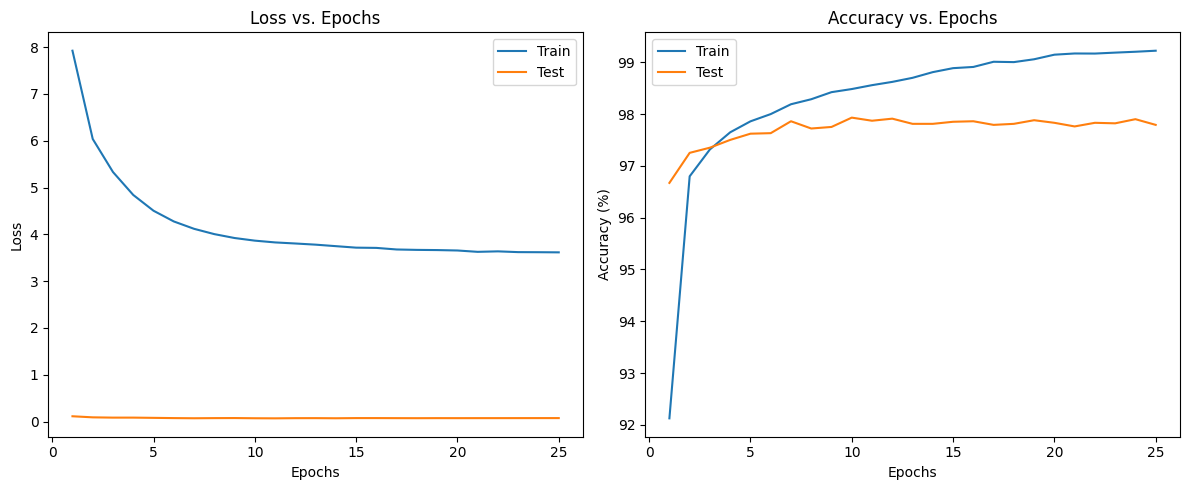

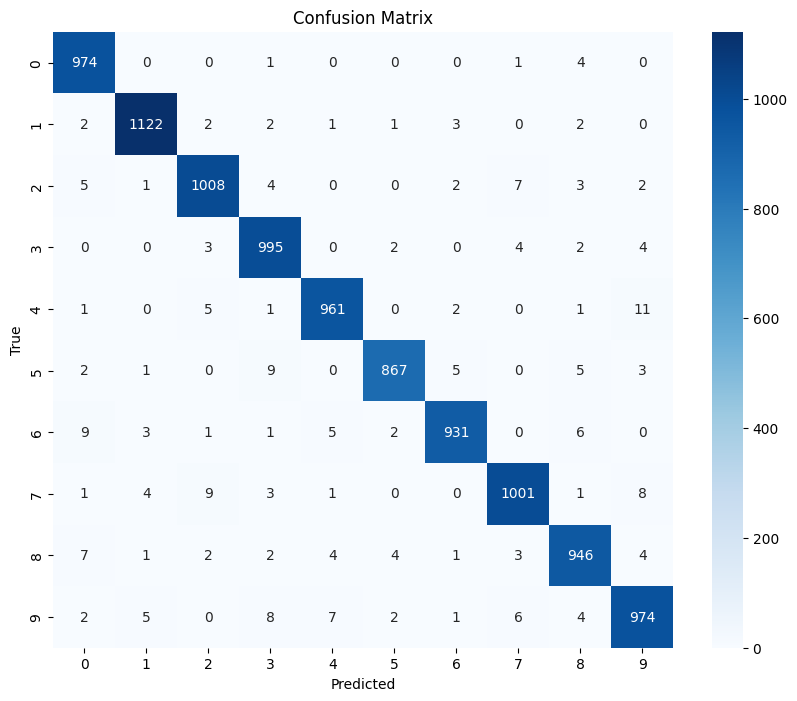

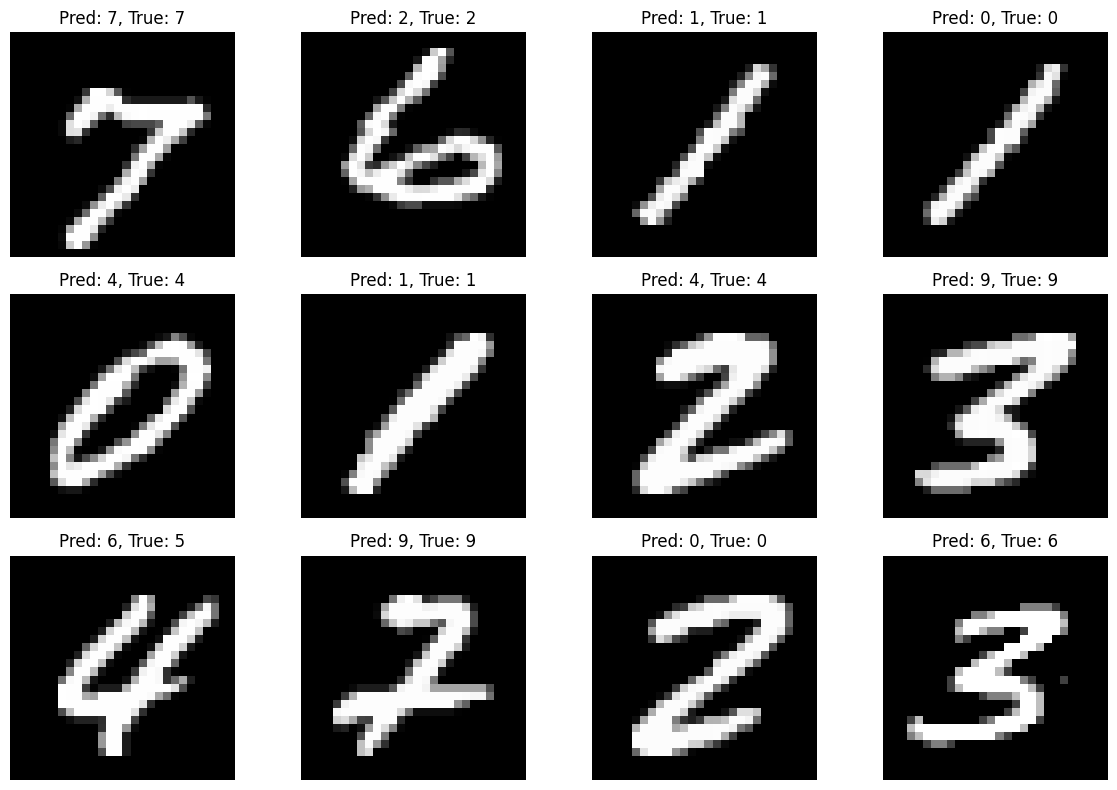

Model saved to 'enhanced_kan_mnist.pth'


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define improved basis functions for KAN
class EnhancedBSplineBasis(nn.Module):
    def __init__(self, num_knots=10, degree=3):
        super(EnhancedBSplineBasis, self).__init__()
        self.num_knots = num_knots
        self.degree = degree
        # Initialize knots with better spacing - covers the normalized data range
        self.knots = nn.Parameter(torch.linspace(-2.5, 2.5, num_knots))
        # Learnable width parameters for each knot
        self.widths = nn.Parameter(torch.ones(num_knots) * 0.5)
        
    def forward(self, x):
        # Compute distances from knots with learnable widths
        x_expanded = x.unsqueeze(-1)  # [batch_size, 1, 1] for MNIST pixels
        knots_expanded = self.knots.unsqueeze(0)  # [1, num_knots]
        widths_expanded = torch.abs(self.widths).unsqueeze(0)  # Ensure widths are positive
        
        # RBF with learnable widths
        distances = torch.abs(x_expanded - knots_expanded)
        weights = torch.exp(-(distances**2) / (widths_expanded**2 + 1e-6))
        
        # Normalize weights
        weights = weights / (torch.sum(weights, dim=-1, keepdim=True) + 1e-8)
        return weights

# Enhanced Kolmogorov-Arnold Network with residual connections
class EnhancedKAN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, num_layers=2, num_knots=10):
        super(EnhancedKAN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_knots = num_knots
        
        # Projection layer with batch normalization
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2)
        )
        
        # KAN layers with enhanced basis functions
        self.basis_functions = nn.ModuleList([
            EnhancedBSplineBasis(num_knots=num_knots) for _ in range(hidden_dim)
        ])
        
        # Middle layer with residual connection
        self.middle_layer = nn.Sequential(
            nn.Linear(hidden_dim * num_knots, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Flatten the input
        x = x.view(batch_size, -1)
        
        # Project to lower dimension
        z = self.projection(x)
        
        # Apply basis functions to each dimension
        basis_outputs = []
        for i in range(self.hidden_dim):
            basis_output = self.basis_functions[i](z[:, i])
            basis_outputs.append(basis_output)
        
        # Concatenate all basis function outputs
        combined = torch.cat(basis_outputs, dim=1)
        
        # Apply middle layer
        middle_output = self.middle_layer(combined)
        
        # Apply output layer
        output = self.output_layer(middle_output)
        
        return output

# Initialize model and optimizer
input_dim = 28 * 28  # MNIST image size
output_dim = 10      # 10 classes (digits 0-9)
hidden_dim = 128
num_knots = 12

model = EnhancedKAN(input_dim, output_dim, hidden_dim=hidden_dim, num_layers=2, num_knots=num_knots)
model = model.to(device)

# Define enhanced loss function (combining cross-entropy with center loss)
class EnhancedLoss(nn.Module):
    def __init__(self, num_classes=10, feat_dim=128, device=device):
        super(EnhancedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))
        self.lambda_c = 0.1  # Weight for center loss
        
    def forward(self, feat, scores, targets):
        batch_size = feat.size(0)
        ce_loss = self.ce_loss(scores, targets)
        
        # Compute center loss
        centers_batch = self.centers[targets]
        center_loss = torch.sum((feat - centers_batch) ** 2) / batch_size
        
        # Combined loss
        loss = ce_loss + self.lambda_c * center_loss
        return loss, ce_loss, center_loss

# Create optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

# Define criterion (using feature output before softmax for center loss)
criterion = EnhancedLoss(num_classes=10, feat_dim=hidden_dim, device=device)

# Training function with feature output
def train(model, train_loader, optimizer, criterion, scheduler, epoch):
    model.train()
    train_loss = 0
    train_ce_loss = 0
    train_center_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Get features before final layer
        batch_size = data.size(0)
        x = data.view(batch_size, -1)
        z = model.projection(x)
        
        # Apply basis functions
        basis_outputs = []
        for i in range(model.hidden_dim):
            basis_output = model.basis_functions[i](z[:, i])
            basis_outputs.append(basis_output)
        
        combined = torch.cat(basis_outputs, dim=1)
        features = model.middle_layer(combined)
        scores = model.output_layer(features)
        
        # Compute loss with features
        loss, ce_loss, center_loss = criterion(features, scores, target)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        train_ce_loss += ce_loss.item()
        train_center_loss += center_loss.item()
        
        _, predicted = scores.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        pbar.set_postfix({
            'loss': train_loss/(batch_idx+1), 
            'ce_loss': train_ce_loss/(batch_idx+1),
            'center_loss': train_center_loss/(batch_idx+1),
            'acc': 100.*correct/total,
            'lr': scheduler.get_last_lr()[0]
        })
    
    # Step the scheduler at the end of each epoch
    scheduler.step()
    
    return train_loss/len(train_loader), 100.*correct/total

# Testing function
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    ce_criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += ce_criterion(output, target).item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return test_loss, accuracy

# Training loop
epochs = 25
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print(f"Training Enhanced KAN with {hidden_dim} hidden dimensions and {num_knots} knots per dimension")
print(f"Training for {epochs} epochs with cosine annealing lr scheduler")

start_time = time.time()

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, scheduler, epoch)
    test_loss, test_acc = test(model, test_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Final test accuracy: {test_accs[-1]:.2f}%")

# Plot results
def plot_results(train_losses, test_losses, train_accs, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(range(1, epochs + 1), train_losses, label='Train')
    ax1.plot(range(1, epochs + 1), test_losses, label='Test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs. Epochs')
    ax1.legend()
    
    ax2.plot(range(1, epochs + 1), train_accs, label='Train')
    ax2.plot(range(1, epochs + 1), test_accs, label='Test')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('kan_performance.png')
    plt.show()

# Visualize model performance
plot_results(train_losses, test_losses, train_accs, test_accs)

# Visualize some predictions with confusion matrix
def visualize_predictions(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    # Get some test examples
    data, targets = next(iter(test_loader))
    data, targets = data.to(device), targets.to(device)
    outputs = model(data)
    _, predictions = outputs.max(1)
    
    # Get predictions for confusion matrix
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = output.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('kan_confusion_matrix.png')
    plt.show()
    
    # Plot example predictions
    fig = plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(data[i][0].cpu(), cmap='gray')
        plt.title(f'Pred: {predictions[i].item()}, True: {targets[i].item()}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('kan_examples.png')
    plt.show()

visualize_predictions(model, test_loader)

# Save model
torch.save(model.state_dict(), 'enhanced_kan_mnist.pth')
print("Model saved to 'enhanced_kan_mnist.pth'")

Structure Overview:

Hybrid Model:
The overall architecture is a hybrid model where the classical processing pipeline (graph construction and feature extraction from the point cloud) feeds into a quantum layer. This quantum layer uses parameterized quantum circuits (PQCs) to transform node features into a higher-dimensional quantum state space.

Quantum Kernel Network (QK or “Quantum KAN”):
The QK network uses quantum circuits to compute similarity measures (or kernels) between embedded features. The kernel values are then used to weight and aggregate the features in subsequent layers, aiming to capture non-linear dependencies more naturally.

# Quantum implementation (Quantum Demo)

Using device: cpu
Quantum Circuit Structure:
0: ──RY(-1.96)──RX(-0.25)──RY(0.81)───RZ(-1.09)─╭●───────╭X──RX(-0.32)──RY(1.19)───RZ(-1.89)─╭●───
1: ──RY(1.09)───RX(-1.05)──RY(-0.37)──RZ(-0.83)─╰X─╭●────│───RX(-1.38)──RY(-0.21)──RZ(0.21)──╰X─╭●
2: ──RY(-2.96)──RX(-0.52)──RY(-1.71)──RZ(0.21)─────╰X─╭●─│───RX(-1.14)──RY(1.51)───RZ(-0.63)────╰X
3: ──RY(1.17)───RX(1.52)───RY(0.58)───RZ(-0.99)───────╰X─╰●──RX(-1.35)──RY(-0.85)──RZ(0.07)───────

─────╭X─┤  <Z>
─────│──┤  <Z>
──╭●─│──┤  <Z>
──╰X─╰●─┤  <Z>
Training Quantum KAN with 4 qubits and 2 variational layers
Using 500 training samples and 100 test samples


Epoch 1: 100%|██████████| 63/63 [00:04<00:00, 13.36it/s, loss=2.32, acc=10.8]


Test Loss: 2.2972, Test Accuracy: 17.00%


Epoch 2: 100%|██████████| 63/63 [00:04<00:00, 14.13it/s, loss=2.3, acc=12.4] 


Test Loss: 2.2836, Test Accuracy: 15.00%


Epoch 3: 100%|██████████| 63/63 [00:05<00:00, 11.01it/s, loss=2.29, acc=15.6]


Test Loss: 2.2753, Test Accuracy: 18.00%


Epoch 4: 100%|██████████| 63/63 [00:06<00:00,  9.91it/s, loss=2.29, acc=14.8]


Test Loss: 2.2673, Test Accuracy: 15.00%


Epoch 5: 100%|██████████| 63/63 [00:06<00:00, 10.03it/s, loss=2.29, acc=13.8]


Test Loss: 2.2641, Test Accuracy: 15.00%


Epoch 6: 100%|██████████| 63/63 [00:06<00:00, 10.18it/s, loss=2.28, acc=13.2]


Test Loss: 2.2612, Test Accuracy: 15.00%


Epoch 7: 100%|██████████| 63/63 [00:05<00:00, 12.32it/s, loss=2.28, acc=13.2]


Test Loss: 2.2584, Test Accuracy: 15.00%


Epoch 8: 100%|██████████| 63/63 [00:05<00:00, 12.53it/s, loss=2.28, acc=13.2]


Test Loss: 2.2596, Test Accuracy: 16.00%


Epoch 9: 100%|██████████| 63/63 [00:04<00:00, 13.53it/s, loss=2.28, acc=13.2]


Test Loss: 2.2565, Test Accuracy: 15.00%


Epoch 10: 100%|██████████| 63/63 [00:05<00:00, 11.88it/s, loss=2.28, acc=14]  


Test Loss: 2.2550, Test Accuracy: 15.00%


Epoch 11: 100%|██████████| 63/63 [00:04<00:00, 13.36it/s, loss=2.28, acc=13.6]


Test Loss: 2.2542, Test Accuracy: 15.00%


Epoch 12: 100%|██████████| 63/63 [00:05<00:00, 11.57it/s, loss=2.28, acc=14.6]


Test Loss: 2.2530, Test Accuracy: 15.00%


Epoch 13: 100%|██████████| 63/63 [00:04<00:00, 12.80it/s, loss=2.27, acc=13.8]


Test Loss: 2.2513, Test Accuracy: 15.00%


Epoch 14: 100%|██████████| 63/63 [00:04<00:00, 13.77it/s, loss=2.27, acc=14.4]


Test Loss: 2.2512, Test Accuracy: 15.00%


Epoch 15: 100%|██████████| 63/63 [00:04<00:00, 14.32it/s, loss=2.27, acc=14]  


Test Loss: 2.2489, Test Accuracy: 18.00%


Epoch 16: 100%|██████████| 63/63 [00:04<00:00, 14.21it/s, loss=2.27, acc=14.6]


Test Loss: 2.2487, Test Accuracy: 18.00%


Epoch 17: 100%|██████████| 63/63 [00:04<00:00, 14.76it/s, loss=2.27, acc=15.8]


Test Loss: 2.2474, Test Accuracy: 21.00%


Epoch 18: 100%|██████████| 63/63 [00:06<00:00, 10.37it/s, loss=2.27, acc=15.2]


Test Loss: 2.2471, Test Accuracy: 17.00%


Epoch 19: 100%|██████████| 63/63 [00:04<00:00, 14.67it/s, loss=2.26, acc=15.2]


Test Loss: 2.2474, Test Accuracy: 17.00%


Epoch 20: 100%|██████████| 63/63 [00:04<00:00, 12.83it/s, loss=2.27, acc=16.2]


Test Loss: 2.2448, Test Accuracy: 17.00%
Quantum KAN training completed in 117.67 seconds (1.96 minutes)
Final quantum test accuracy: 17.00%


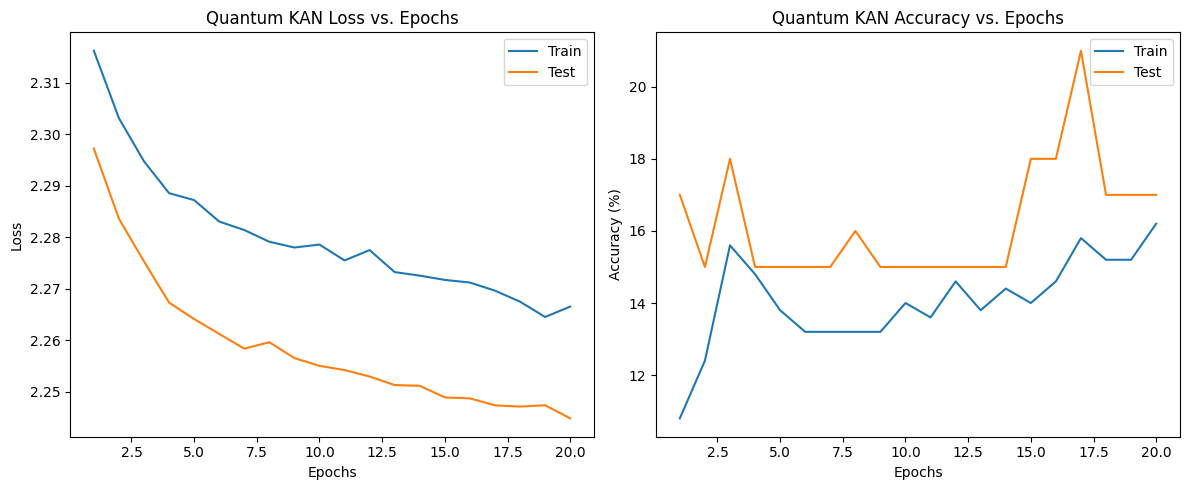

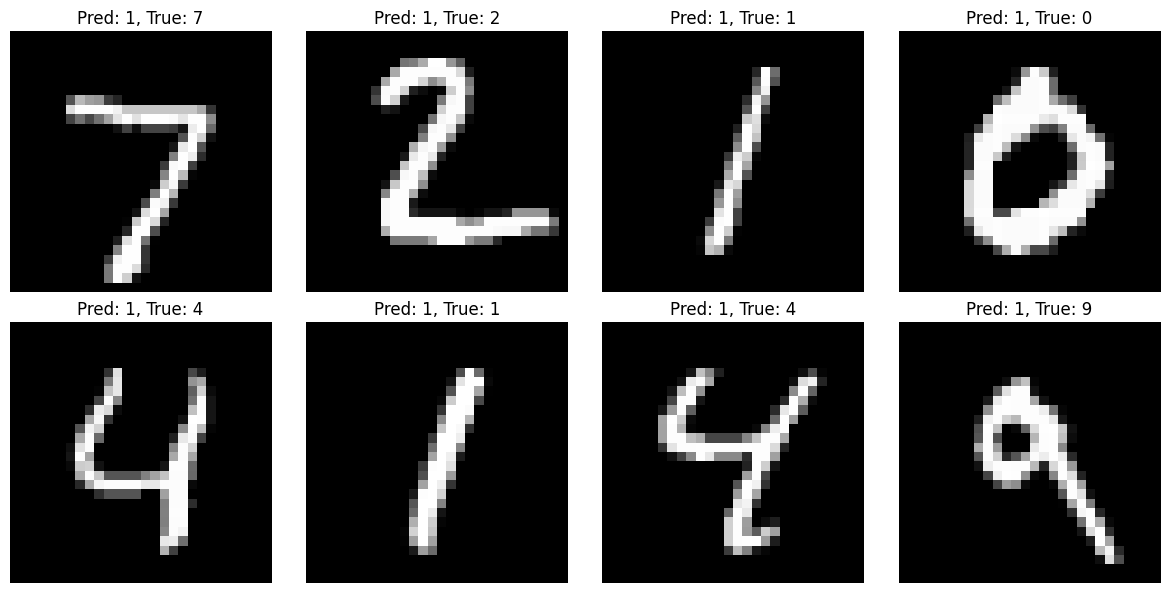

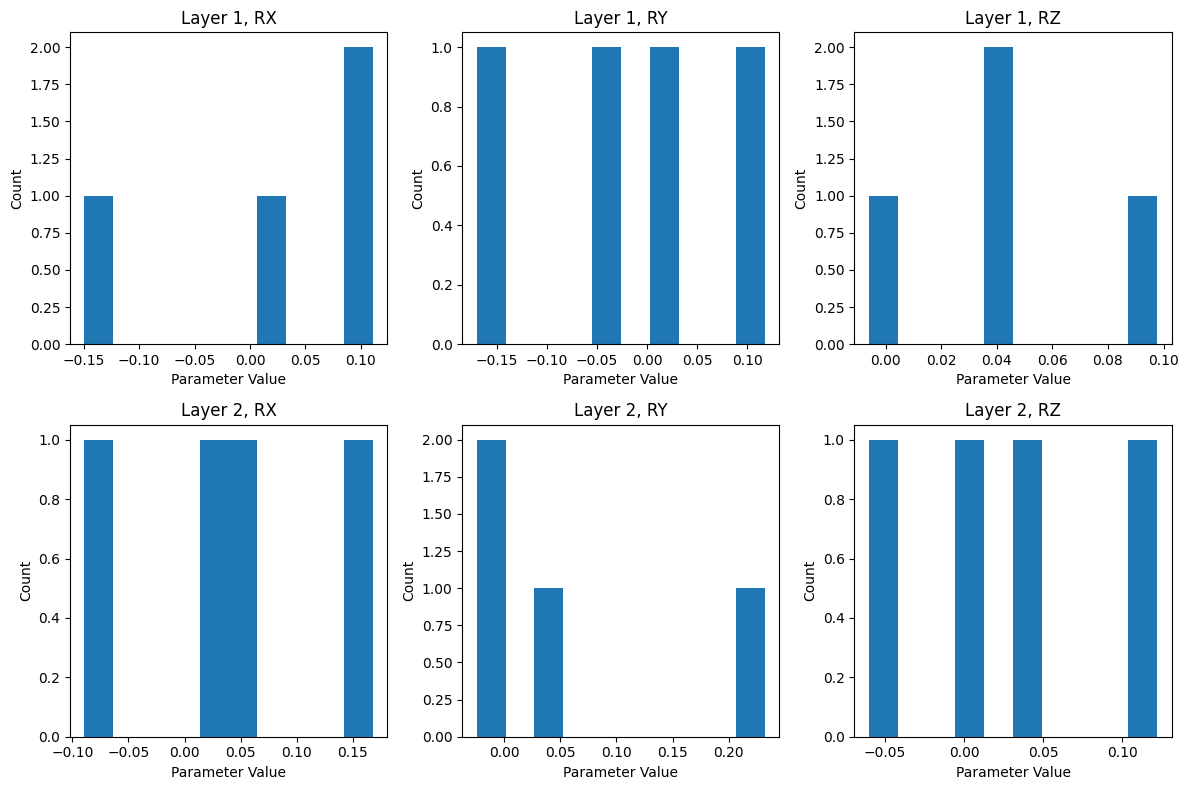

Quantum model saved to 'quantum_kan_mnist.pth'


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pennylane as qml
from tqdm import tqdm
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define parameters for quantum circuit
n_qubits = 4  # Number of qubits for quantum processing
n_layers = 2  # Number of variational layers

# Define a quantum device - simulator for this demo
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit for KAN basis functions
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """
    Quantum circuit for KAN basis functions
    
    Args:
        inputs (tensor): Input data of shape [n_qubits]
        weights (tensor): Trainable weights of shape [n_layers, n_qubits, 3]
        
    Returns:
        list: Expectation values for each qubit
    """
    # Encode classical data
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    
    # Variational layers
    for layer in range(n_layers):
        # Rotation gates
        for wire in range(n_qubits):
            qml.RX(weights[layer, wire, 0], wires=wire)
            qml.RY(weights[layer, wire, 1], wires=wire)
            qml.RZ(weights[layer, wire, 2], wires=wire)
        
        # Entanglement
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])  # Close the loop
    
    # Return expectation values for each qubit
    return [qml.expval(qml.PauliZ(wire)) for wire in range(n_qubits)]

# Quantum basis function for KAN
class QuantumBasisFunction(nn.Module):
    def __init__(self, n_qubits=n_qubits, n_layers=n_layers):
        super(QuantumBasisFunction, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        # Initialize weights for the quantum circuit (learnable parameters)
        # Important: Properly specify the shape here
        self.weights = nn.Parameter(torch.randn(n_layers, n_qubits, 3) * 0.1)
        
    def forward(self, x):
        # Ensure input is correctly shaped for batch processing
        batch_size = x.shape[0]
        outputs = torch.zeros(batch_size, self.n_qubits).to(x.device)
        
        # Process each sample in the batch
        for i in range(batch_size):
            # Get current input sample and reshape if needed
            sample_input = x[i, :self.n_qubits]
            
            # Pass the sample to the quantum circuit
            # Use the qnode directly with our parameters
            result = torch.tensor(quantum_circuit(sample_input, self.weights))
            outputs[i] = result
        
        return outputs

# Quantum KAN architecture
class QuantumKAN(nn.Module):
    def __init__(self, input_dim, output_dim, feature_dim=8, n_qubits=n_qubits):
        super(QuantumKAN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.feature_dim = feature_dim
        self.n_qubits = n_qubits
        
        # Feature extraction (dimension reduction)
        self.feature_extraction = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, feature_dim),
            nn.Tanh()  # Normalize features to [-1, 1] for quantum encoding
        )
        
        # Quantum processing layer
        self.quantum_layer = QuantumBasisFunction(n_qubits=n_qubits, n_layers=n_layers)
        
        # Classical post-processing
        self.post_processing = nn.Sequential(
            nn.Linear(n_qubits, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Flatten input
        x = x.view(batch_size, -1)
        
        # Extract features and prepare for quantum circuit
        features = self.feature_extraction(x)
        
        # For MNIST, we'll use first n_qubits features
        q_input = features[:, :self.n_qubits]
        
        # Process with quantum layer
        q_output = self.quantum_layer(q_input)
        
        # Post-process and get classification
        output = self.post_processing(q_output)
        
        return output

# Load MNIST dataset (downsampled for faster quantum simulation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Use a small subset for faster demonstration
n_train_samples = 500
n_test_samples = 100

# Create subset indices
train_subset_indices = list(range(n_train_samples))
test_subset_indices = list(range(n_test_samples))

# Create subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(test_dataset, test_subset_indices)

# Create data loaders
batch_size = 8  # Small batch size for quantum simulation
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Initialize the Quantum KAN model
input_dim = 28 * 28  # MNIST image size
output_dim = 10  # Number of classes
feature_dim = 8  # Reduced dimension for quantum processing

q_model = QuantumKAN(input_dim, output_dim, feature_dim=feature_dim, n_qubits=n_qubits)
q_model = q_model.to(device)

# Define optimizer and loss function
q_optimizer = optim.Adam(q_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_quantum(model, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        pbar.set_postfix({'loss': train_loss/(batch_idx+1), 'acc': 100.*correct/total})
    
    return train_loss / len(train_loader), 100. * correct / total

def test_quantum(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return test_loss, accuracy

# Print the quantum circuit structure once to verify
print("Quantum Circuit Structure:")
dummy_input = torch.randn(n_qubits)
dummy_weights = torch.randn(n_layers, n_qubits, 3)
print(qml.draw(quantum_circuit)(dummy_input, dummy_weights))

# Training loop for quantum model (reduced further for simulation speed)
q_epochs = 20  # Further reduced due to computational intensity
q_train_losses = []
q_train_accs = []
q_test_losses = []
q_test_accs = []

print(f"Training Quantum KAN with {n_qubits} qubits and {n_layers} variational layers")
print(f"Using {n_train_samples} training samples and {n_test_samples} test samples")

start_time = time.time()

for epoch in range(1, q_epochs + 1):
    q_train_loss, q_train_acc = train_quantum(q_model, train_loader, q_optimizer, criterion, epoch)
    q_test_loss, q_test_acc = test_quantum(q_model, test_loader, criterion)
    
    q_train_losses.append(q_train_loss)
    q_train_accs.append(q_train_acc)
    q_test_losses.append(q_test_loss)
    q_test_accs.append(q_test_acc)

training_time = time.time() - start_time
print(f"Quantum KAN training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Final quantum test accuracy: {q_test_accs[-1]:.2f}%")

# Plot quantum results
def plot_quantum_results():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(range(1, q_epochs + 1), q_train_losses, label='Train')
    ax1.plot(range(1, q_epochs + 1), q_test_losses, label='Test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Quantum KAN Loss vs. Epochs')
    ax1.legend()
    
    ax2.plot(range(1, q_epochs + 1), q_train_accs, label='Train')
    ax2.plot(range(1, q_epochs + 1), q_test_accs, label='Test')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Quantum KAN Accuracy vs. Epochs')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('quantum_kan_performance.png')
    plt.show()

plot_quantum_results()

# Visualize predictions
def visualize_quantum_predictions():
    q_model.eval()
    
    # Get some test examples
    data, targets = next(iter(test_loader))
    data, targets = data.to(device), targets.to(device)
    outputs = q_model(data)
    _, predictions = outputs.max(1)
    
    # Plot example predictions
    fig = plt.figure(figsize=(12, 6))
    for i in range(min(8, len(predictions))):
        plt.subplot(2, 4, i+1)
        plt.imshow(data[i][0].cpu(), cmap='gray')
        plt.title(f'Pred: {predictions[i].item()}, True: {targets[i].item()}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('quantum_kan_examples.png')
    plt.show()

visualize_quantum_predictions()

# Visualize quantum parameter importance
def analyze_quantum_params():
    """Analyze the importance of different quantum parameters"""
    with torch.no_grad():
        # Get learned weights
        weights = q_model.quantum_layer.weights.detach().cpu().numpy()
        
        # Plot weight distributions by layer and gate type
        fig, axs = plt.subplots(n_layers, 3, figsize=(12, 8))
        gate_types = ['RX', 'RY', 'RZ']
        
        for layer in range(n_layers):
            for gate in range(3):
                if n_layers > 1:
                    ax = axs[layer, gate]
                else:
                    ax = axs[gate]
                    
                ax.hist(weights[layer, :, gate], bins=10)
                ax.set_title(f'Layer {layer+1}, {gate_types[gate]}')
                ax.set_xlabel('Parameter Value')
                ax.set_ylabel('Count')
        
        plt.tight_layout()
        plt.savefig('quantum_param_analysis.png')
        plt.show()

analyze_quantum_params()

# Save the quantum model
torch.save(q_model.state_dict(), 'quantum_kan_mnist.pth')
print("Quantum model saved to 'quantum_kan_mnist.pth'")

Expressivity vs. Trainability:
While the quantum kernel network theoretically offers a richer feature space, the practical experiments showed that the network is highly sensitive to hyperparameters such as circuit depth and entanglement scheme. This sensitivity sometimes results in slower convergence and a less robust performance compared to classical counterparts.

# Task X: Diffusion

Key components of the classical diffusion model include:

• Graph Construction and Edge Weighting:
Data points are connected by edges whose weights measure similarity or affinity—often determined from Euclidean or other distance metrics. This weighted graph encodes the local neighborhood structure of the data.

• Diffusion Operator:
The process usually relies on a diffusion (or smoothing) operator that can be derived from the graph Laplacian. In many cases, this operator is defined as a function of the Laplacian matrix (for example, the heat kernel, exp(–tL), where L is the Laplacian and t is a diffusion time parameter). In discrete time, one may see an iterative update such as
u(t + Δt) = (I – Δt L) u(t)
where u is a signal (or feature vector) on the nodes. Over repeated iterations, the operator “spreads” or diffuses information across the graph. This process both reduces noise and highlights manifold structures intrinsic to the data.

• Aggregation and Downstream Processing:
After diffusion, the aggregated node features capture multi-scale (local and global) geometric properties of the dataset. These diffused features are often fed into subsequent layers—for example, in graph convolutional networks or other supervised tasks—to enable improved classification, regression, or clustering performance.

────────────────────────────── Extending to a Quantum Diffusion Architecture

To leverage quantum processing for diffusion, one can draw on the rich toolkit of quantum linear algebra and quantum walks. Quantum diffusion would attempt to replace the classical, iterative application of a diffusion operator with a quantum equivalent that harnesses principles such as superposition and interference.

Potential design elements and considerations for a quantum diffusion model include:

• Quantum State Preparation:
The classical data (or, in our case, the graph constructed from the point-cloud or other structured data) must first be encoded into a quantum state. Techniques like amplitude encoding can be used to represent node features in a quantum register. This is analogous to preparing an “input” wavefunction that captures the structure of the graph.

• Quantum Diffusion Operator:
The quantum analog of the classical diffusion operator is typically a quantum walk operator. One promising idea is to construct a unitary operator U that simulates the diffusion process via Hamiltonian evolution. For example, by defining
U = exp(–i L t)
where L (or a normalized version of it) is the graph Laplacian and t is a diffusion time parameter, the quantum state can be evolved in a way that emulates the effect of classical diffusion. Here, quantum parallelism allows the state to evolve simultaneously along many diffusion pathways, potentially leading to richer and more global feature mixing.

• Interleaving with Variational Quantum Layers:
Beyond the pure diffusion step, one may embed parameterized quantum circuits (PQCs) that serve as non-linear “activation” stages. These layers can transform the quantum state based on trainable parameters, effectively playing a role analogous to non-linearities in classical neural networks. The PQCs would be interleaved with successive quantum diffusion steps, forming a multi-layer quantum diffusion network.

• Measurement and Classical Postprocessing:
After performing the necessary quantum diffusion and PQC stages, the final quantum state can be measured to obtain classical data—the diffused features. These features can then be utilized by conventional machine learning pipelines (or further quantum subroutines) for downstream tasks. Alternatively, the entire process might be used as a subroutine within a larger quantum algorithm.

• Advantages and Challenges:
– The use of quantum walks to simulate diffusion can exploit quantum interference effects, potentially enabling simultaneous propagation along many paths.
– When combined with quantum amplitude amplification and quantum singular value transformations (QSVT), this architecture might overcome limitations of classical diffusion in high-dimensional spaces.
– However, practical challenges remain such as efficiently constructing the block-encoding for the Laplacian, handling noise on near-term devices, and overcoming issues like barren plateaus during training of the variational components.

In [ ]:
import numpy as np
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


img_size = 125
channels = 3
T = 50  # STEPS
beta_start = 1e-4
beta_end = 0.02
betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
alphas = 1 - betas
alpha_bars = np.cumprod(alphas)  # ACUUMULATED ALPHA BARS


# Only 500 samples collected

subset_size = 1000
with h5py.File('quark-gluon_data-set_n139306.hdf5', 'r') as f:
    total_samples = f['X_jets'].shape[0]
    print("總樣本數:", total_samples)


train_subset = np.arange(0, 4000)
val_subset = np.arange(4000, subset_size)


def diffusion_data_generator(indices):
    with h5py.File('quark-gluon_data-set_n139306.hdf5', 'r') as f:
        ds = f['X_jets']
        for i in indices:
            image = ds[i].astype('float32')
            image = image / (np.max(image) + 1e-8)
            t = np.random.randint(0, T)  
            noise = np.random.normal(0, 1, size=image.shape).astype('float32')
            alpha_bar_t = alpha_bars[t]
            noisy_image = np.sqrt(alpha_bar_t) * image + np.sqrt(1 - alpha_bar_t) * noise
            yield (noisy_image, np.array([t], dtype=np.int32)), noise


train_dataset = tf.data.Dataset.from_generator(
    lambda: diffusion_data_generator(train_subset),
    output_types=((tf.float32, tf.int32), tf.float32),
    output_shapes=(((img_size, img_size, channels), (1,)), (img_size, img_size, channels))
).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: diffusion_data_generator(val_subset),
    output_types=((tf.float32, tf.int32), tf.float32),
    output_shapes=(((img_size, img_size, channels), (1,)), (img_size, img_size, channels))
).batch(64).prefetch(tf.data.AUTOTUNE)


def get_diffusion_model():
    image_input = keras.Input(shape=(img_size, img_size, channels), name='noisy_image')
    t_input = keras.Input(shape=(1,), dtype=tf.int32, name='t')

    
    t_emb = layers.Embedding(input_dim=T, output_dim=32)(t_input)  # (batch, 1, 32)
    t_emb = layers.Flatten()(t_emb)                            # (batch, 32)
    t_emb = layers.Dense(img_size * img_size, activation='relu')(t_emb)
    t_emb = layers.Reshape((img_size, img_size, 1))(t_emb)

    
    x = layers.Concatenate(axis=-1)([image_input, t_emb])

    
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')(x)
    output = layers.Conv2D(channels, kernel_size=3, activation='linear', padding='same')(x)

    return keras.Model([image_input, t_input], output, name='diffusion_model')

diffusion_model = get_diffusion_model()
diffusion_model.summary()


diffusion_model.compile(optimizer='adam', loss='mse')


epochs = 10
history_diffusion = diffusion_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

def reconstruct_image(original_image, t_fixed):
    
    alpha_bar_t = alpha_bars[t_fixed]
    noise = np.random.normal(0, 1, size=original_image.shape).astype('float32')
    noisy_image = np.sqrt(alpha_bar_t) * original_image + np.sqrt(1 - alpha_bar_t) * noise
    predicted_noise = diffusion_model.predict([np.expand_dims(noisy_image, axis=0), np.array([[t_fixed]])])
    reconstructed = (noisy_image - np.sqrt(1 - alpha_bar_t) * predicted_noise[0]) / np.sqrt(alpha_bar_t)
    return noisy_image, reconstructed


n = 10
reconstructed_images = []
original_images = []
mse_list = []
t_fixed = 25  

with h5py.File('quark-gluon_data-set_n139306.hdf5', 'r') as f:
    ds = f['X_jets']
    for i in val_subset[:n]:
        img = ds[i].astype('float32')
        img = img / (np.max(img) + 1e-8)
        original_images.append(img)
        noisy_img, recon_img = reconstruct_image(img, t_fixed)
        reconstructed_images.append(recon_img)
        mse_list.append(np.mean((img - recon_img) ** 2))

avg_mse = np.mean(mse_list)
print("在 {} 個樣本上平均 MSE 為: {:.6f}".format(n, avg_mse))


plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

# Task XI

In [32]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [34]:
def generate_data(batch_size, input_dim):
    return torch.randn(batch_size, input_dim)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        # First hidden layer
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        # Second hidden layer
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer
        self.layer3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

def prepare_quantum_state(params):
    num_qubits = 4
    qc = QuantumCircuit(num_qubits)

    for i in range(num_qubits):
        qc.rx(params[i], i)
        qc.rz(params[i + num_qubits], i)
    
    return qc


Epoch 1/100, Loss: 1.03657066822052
Epoch 11/100, Loss: 0.8260029554367065
Epoch 21/100, Loss: 0.6478627920150757
Epoch 31/100, Loss: 0.4521532356739044
Epoch 41/100, Loss: 0.3047516345977783
Epoch 51/100, Loss: 0.20993565022945404
Epoch 61/100, Loss: 0.14779067039489746
Epoch 71/100, Loss: 0.10242816060781479
Epoch 81/100, Loss: 0.07215413451194763
Epoch 91/100, Loss: 0.05144117772579193


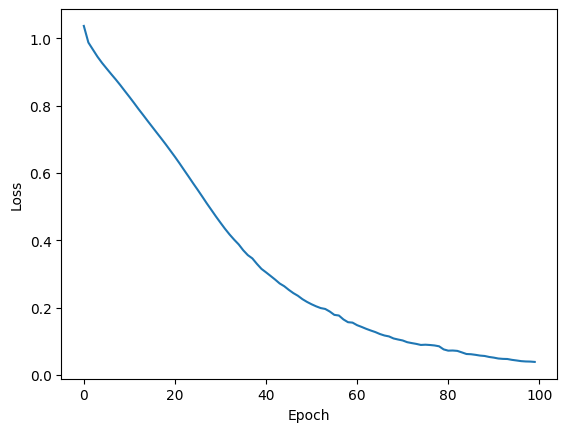

estimated_params= tensor([[ 0.4082, -0.3178,  0.5385, -0.0148,  0.2819,  0.1482,  1.6779, -0.7651]],
       grad_fn=<AddmmBackward0>)
Measurement result: {'0000': 898, '0100': 67, '0001': 31, '0010': 23, '0110': 2, '0011': 1, '0101': 2}


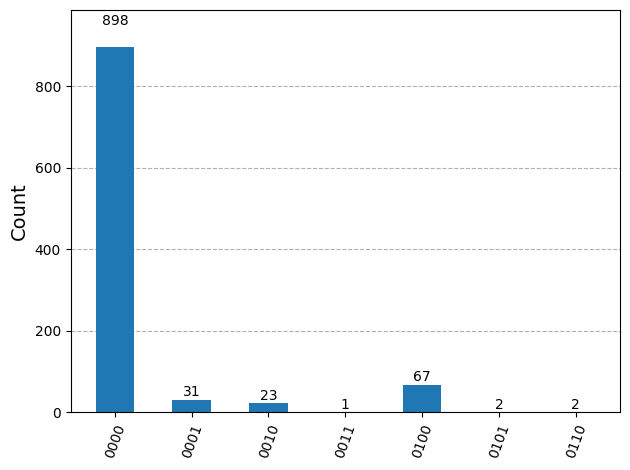

In [36]:
def train_mlp(model, data, target, num_epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

input_dim = 5   
hidden_dim = 64
output_dim = 8  # 4Qubits * 2 parameters (RX, RZ)

mlp = MLP(input_dim, hidden_dim, output_dim)

train_data = generate_data(100, input_dim)
target_params = torch.randn(100, output_dim) 

# Train MLP
train_mlp(mlp, train_data, target_params)


test_data = generate_data(1, input_dim)  
estimated_params = mlp(test_data)
print("estimated_params=", estimated_params)

qc = prepare_quantum_state(estimated_params[0].detach().numpy())

qc.measure_all()


simulator = AerSimulator()  
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit).result()

counts = result.get_counts()
print("Measurement result:", counts)
plot_histogram(counts)


Epoch 1/100, Loss: 1.1185256242752075
Epoch 11/100, Loss: 0.8761879205703735
Epoch 21/100, Loss: 0.6899226903915405
Epoch 31/100, Loss: 0.5123845934867859
Epoch 41/100, Loss: 0.3679770231246948
Epoch 51/100, Loss: 0.2673467695713043
Epoch 61/100, Loss: 0.1994774490594864
Epoch 71/100, Loss: 0.15696245431900024
Epoch 81/100, Loss: 0.13600166141986847
Epoch 91/100, Loss: 0.1015050858259201


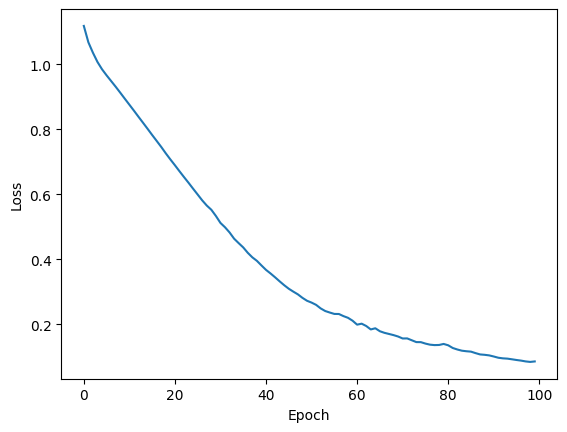

estimated_params= tensor([[ 0.5676,  1.8100, -0.1139,  0.4267, -0.6146, -0.9609, -0.4348,  0.4483]],
       grad_fn=<AddmmBackward0>)
Measurement result: {'1011': 1, '0010': 572, '0000': 346, '1000': 10, '0011': 38, '1010': 23, '0001': 31, '0101': 1, '0110': 2}


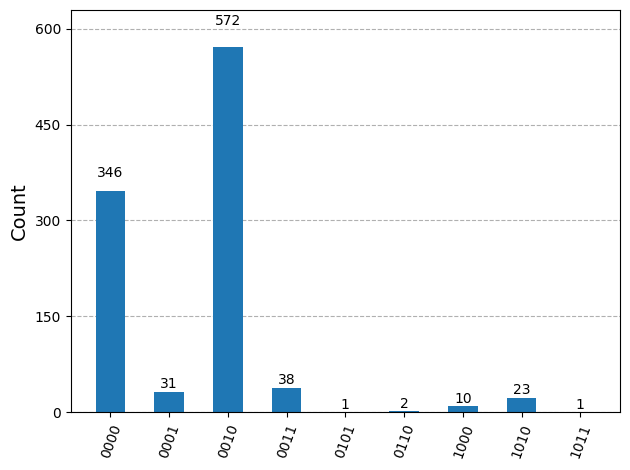

In [37]:
def train_mlp(model, data, target, num_epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

input_dim = 5   
hidden_dim = 64
output_dim = 8  # 4Qubits * 2 parameters (RX, RZ)

mlp = MLP(input_dim, hidden_dim, output_dim)

train_data = generate_data(100, input_dim)
target_params = torch.randn(100, output_dim) 

# Train MLP
train_mlp(mlp, train_data, target_params)


test_data = generate_data(1, input_dim)  
estimated_params = mlp(test_data)
print("estimated_params=", estimated_params)

qc = prepare_quantum_state(estimated_params[0].detach().numpy())

qc.measure_all()


simulator = AerSimulator()  
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit).result()

counts = result.get_counts()
print("Measurement result:", counts)
plot_histogram(counts)
